# Winter data for Upper Slope 75 kHz ADCP
**Full depth tidal filters from January 1 - February 28, 2018**

## Imports

In [2]:
import qgrid
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as pldates
import numpy as np
import scipy.signal as sig
import scipy.interpolate as interp
import pandas as pd
from scipy.stats import chi2
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib notebook

In [3]:
# Upper Slope January and February

with xr.open_dataset('../Nov11/UpperSlopeJanFeb2018.nc') as ds:
    print(ds)

<xarray.Dataset>
Dimensions:    (depth: 50, latitude: 1, longitude: 1, time: 1404)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-01T00:30:00.000003328 ... 2018-02-28T11:29:59.999996672
  * depth      (depth) float32 378.27 370.27 362.27 354.27 ... 2.27 -5.73 -13.73
  * latitude   (latitude) float32 48.42743
  * longitude  (longitude) float32 -126.17467
Data variables:
    u          (time, depth) float32 ...
    v          (time, depth) float32 ...
    w          (time, depth) float32 ...
    temp       (time) float32 ...
Attributes:
    Conventions:                             CF-1.6
    title:                                   Ocean Networks Canada RDI ADCP Data
    institution:                             Ocean Networks Canada
    source:                                  Fixed-position Teledyne-RDI ADCP...
    history:                                 data extracted from raw output, ...
    references:                              http://www.oceannetworks.ca/
    CREATION

In [6]:
#grid = pd.DataFrame(ds.u)
#qgrid.show_grid(grid, show_toolbar=True)

## Depth

**Find specific depth to remove depth values (unreliable data, from visual inspection of initial plots), about 100m at the top**

In [4]:
# find specific depth to remove depth values (unreliable data, from visual inspection of initial plots)
# about 100m at the top
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx     # returns index of nearest value

array = ds.depth
upval = 100        # meters
upidx = find_nearest(array, upval)

print("Index at cutoff:", find_nearest(array, upval))
print("Value at cutoff:", abs(array[find_nearest(array, upval)]))

depth = np.array(ds.depth[0:upidx+1])       # remove unwanted upper depths

print('---')
print("Length of new depth array: ", len(depth))
print('Lower limit at',-depth[6],'metres') # depth for lower PSD
print('Upper limit at',-depth[30],'metres')# depth for upper PSD

Index at cutoff: 35
Value at cutoff: <xarray.DataArray 'depth' ()>
array(98.27, dtype=float32)
Coordinates:
    depth    float32 98.27
---
Length of new depth array:  36
Lower limit at -330.27 metres
Upper limit at -138.27 metres


## Filter

**Low pass Butterworth filter for 40 hours to remove 30 hour tides**

In [5]:
# low pass Butterworth filter for 40 hours to remove 30 hour tides

fs = 1                # 1 sample per HOUR for entire time series
fc = 0.025            # 40 hour low pass filter
Wn = fc / (fs / 2)    # normalised cut-off frequencies
b, a = sig.butter(12, Wn, 'lowpass')  # digital butterworth filter
w, h = sig.freqz(b, a)

<IPython.core.display.Javascript object>


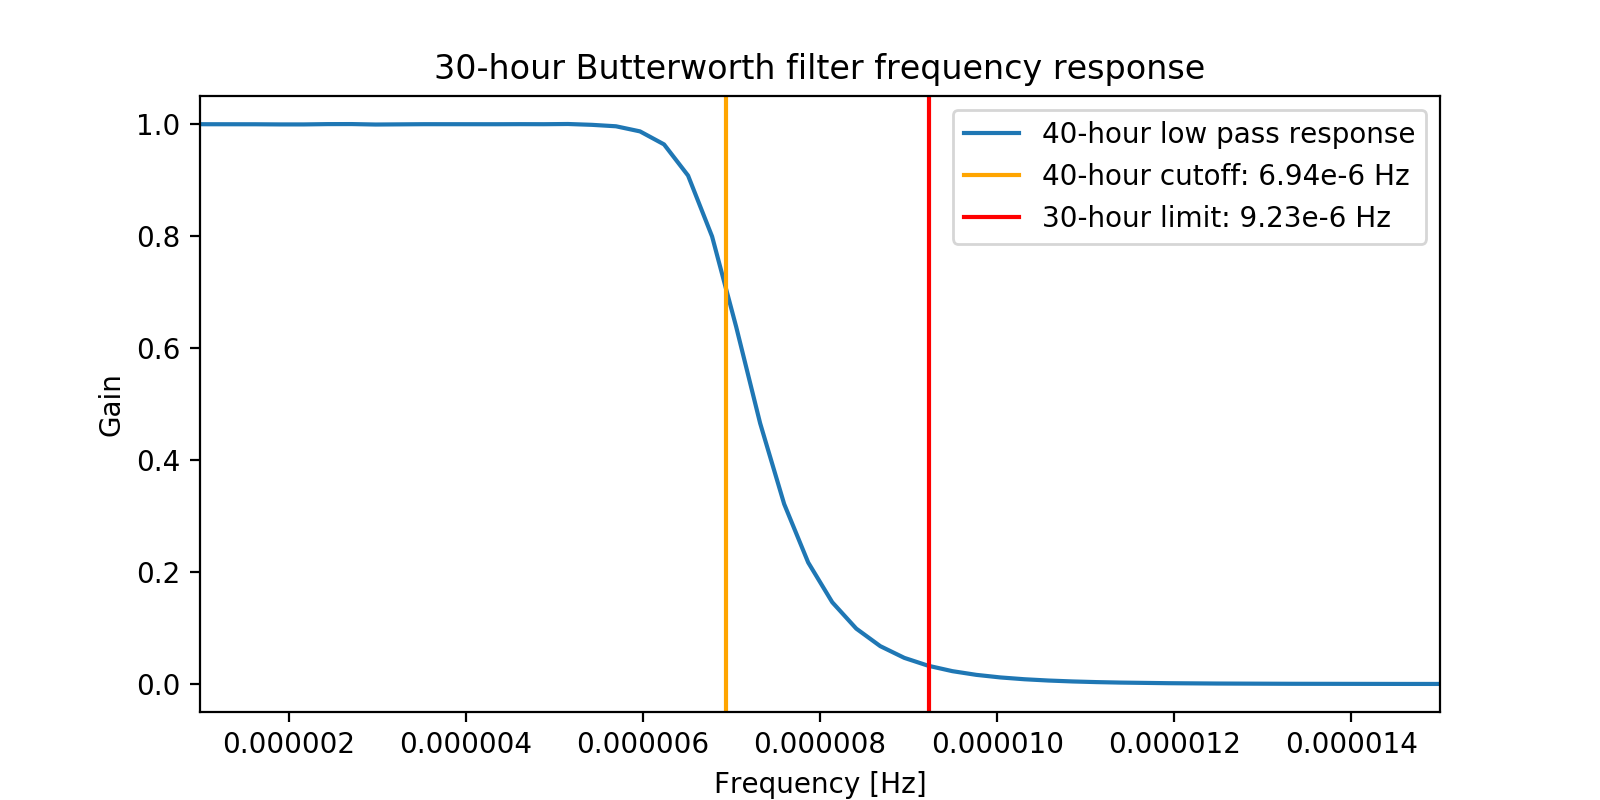

In [6]:
plt.figure(figsize=(8,4))                      # check filter response
plt.plot((1/(2*np.pi))*w / 3600, abs(h), label = "40-hour low pass response") # response in Hz
plt.xlim(1e-6, 1.5e-5)
plt.axvline(6.94e-6, color ='orange', label = "40-hour cutoff: 6.94e-6 Hz")
plt.axvline(9.23e-6, color ='red', label = "30-hour limit: 9.23e-6 Hz")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Gain")
plt.title("30-hour Butterworth filter frequency response")
plt.legend(loc='best')
plt.show()

**Loop to acquire original, filtered, and residual data**

In [7]:
# loop to filter tides from all depths

t = len(ds.time)               # number of time data points
d = len(depth)                 # number of depth data points after removing upper portion
days = t/24                    # number of days
time = np.linspace(0,days,t)   # x-range

In [8]:
uorig = np.empty([t,d])        # empty array for original u data
vorig = np.empty([t,d])        # empty array for original v data
worig = np.empty([t,d])        # empty array for original w data

ulp = np.empty([t,d])          # empty array for low-pass filtered u values
vlp = np.empty([t,d])          # empty array for low-pass filtered v values
wlp = np.empty([t,d])          # empty array for low-pass filtered w values

for j in range(d):
    utemp = pd.Series(ds.u[:,j])
    uint = utemp.interpolate(method="cubic")
    uorig[:,j] = uint                    # set interpolated data to original array
    ulp[:,j] = sig.filtfilt(b, a, uint)  # set low pass array values
    
    vtemp = pd.Series(ds.v[:,j])
    vint = vtemp.interpolate(method="cubic")
    vorig[:,j] = vint                    # set interpolated data to original array
    vlp[:,j] = sig.filtfilt(b, a, vint)  # set low pass array values
    
    wtemp = pd.Series(ds.w[:,j])
    wint = wtemp.interpolate(method="cubic")
    worig[:,j] = wint                    # set interpolated data to original array
    wlp[:,j] = sig.filtfilt(b, a, wint)  # set low pass array values
    
uhp = uorig - ulp
vhp = vorig - vlp
whp = worig - wlp

## Spectra ##

### Depth = -330 meters - Combined

In [9]:
um6 = uorig[:,6] - np.mean(uorig[:,6]) # depth[6] = -330 meters
ulpm6 = ulp[:,6] - np.mean(ulp[:,6])
uhpm6 = uhp[:,6] - np.mean(uhp[:,6])

vm6 = vorig[:,6] - np.mean(vorig[:,6])
vlpm6 = vlp[:,6] - np.mean(vlp[:,6])
vhpm6 = vhp[:,6] - np.mean(vhp[:,6])

wm6 = worig[:,6] - np.mean(worig[:,6])
wlpm6 = wlp[:,6] - np.mean(wlp[:,6])
whpm6 = whp[:,6] - np.mean(whp[:,6])

In [10]:
um_depth = np.zeros(t)         # depth mean spectra
vm_depth = np.zeros(t)
wm_depth = np.zeros(t)
for i in range(t):
    um_depth[i] = np.mean(uorig[i,:])
for i in range(t):
    vm_depth[i] = np.mean(vorig[i,:])
for i in range(t):
    wm_depth[i] = np.mean(worig[i,:])
um_depth -= np.mean(uorig)
vm_depth -= np.mean(vorig)
wm_depth -= np.mean(worig)

In [11]:
#typically use 2**x for nperseg, up to sample size

fs_x = 1
window_x = 'parzen'
nperseg_x = 150        #1404 max

um6_f, um6_PDS = sig.welch(um6, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)
ulpm6_f, ulpm6_PDS = sig.welch(ulpm6, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)
uhpm6_f, uhpm6_PDS = sig.welch(uhpm6, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)

vm6_f, vm6_PDS = sig.welch(vm6, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)
vlpm6_f, vlpm6_PDS = sig.welch(vlpm6, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)
vhpm6_f, vhpm6_PDS = sig.welch(vhpm6, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)

wm6_f, wm6_PDS = sig.welch(wm6, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)
wlpm6_f, wlpm6_PDS = sig.welch(wlpm6, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)
whpm6_f, whpm6_PDS = sig.welch(whpm6, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)

um_depth_f, um_depth_PDS = sig.welch(um_depth, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)
vm_depth_f, vm_depth_PDS = sig.welch(vm_depth, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)
wm_depth_f, wm_depth_PDS = sig.welch(wm_depth, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)

In [12]:
# error bars (95% confidence intervals)


probability = 0.95                      # calculate confidence intervals
alpha = 1 - probability        
NS = len(ds.time) / (nperseg_x / 2)     # number of estimates, Welch
vp = (4/3)*NS                           # for tapered windows
cp = chi2.ppf([1 - alpha / 2, alpha / 2], vp) # chi**2 distribution
cint = vp/cp                            # interval coefficients

um6_lower = um6_PDS * cint[0]           # define upper and lower confidence values
um6_upper = um6_PDS * cint[1]
vm6_lower = vm6_PDS * cint[0]           # define upper and lower confidence values
vm6_upper = vm6_PDS * cint[1]
wm6_lower = wm6_PDS * cint[0]           # define upper and lower confidence values
wm6_upper = wm6_PDS * cint[1]

<IPython.core.display.Javascript object>


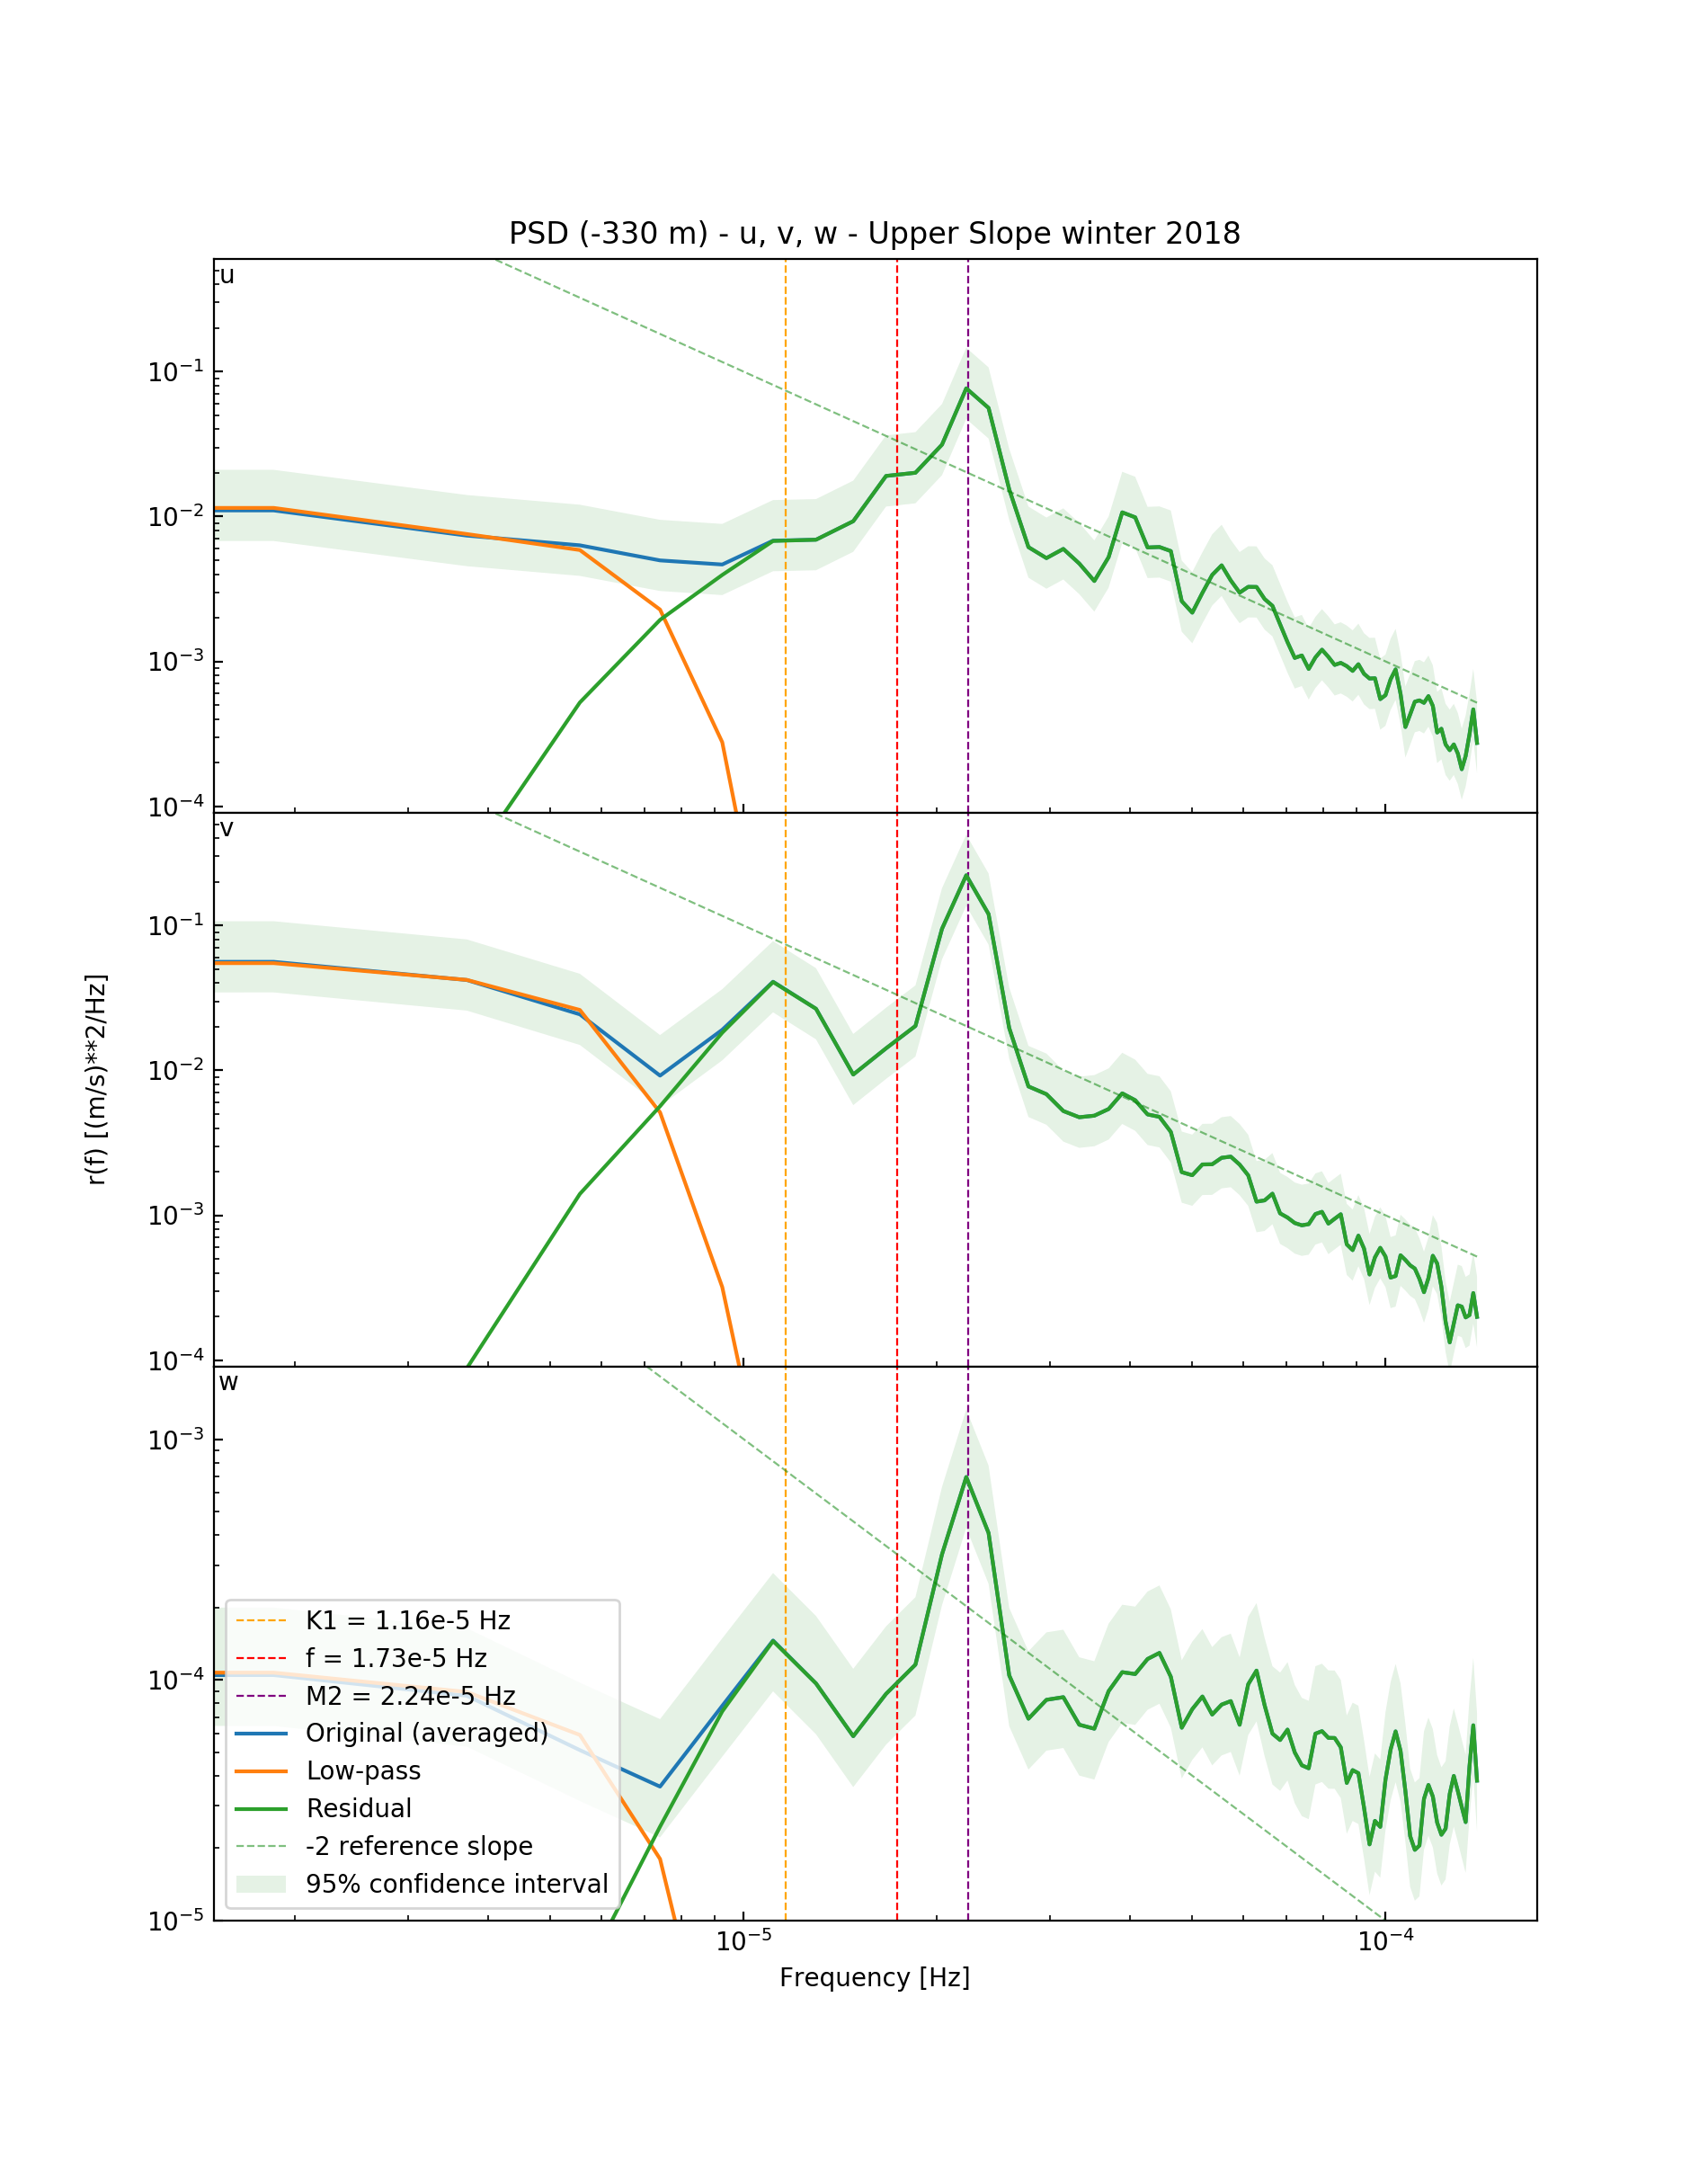

/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in power
/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in power
/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in power


In [13]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(9.5,12), sharex=True)
fig.subplots_adjust(hspace = 0.0)

ax1.axvline(1.161e-5, color ='orange',ls='--',lw=0.8,label = "K1 = 1.16e-5 Hz") # inertial period
ax1.axvline(1.732e-5, color ='red',ls='--', lw=0.8,label = "f = 1.73e-5 Hz")
ax1.axvline(2.236e-5, color ='purple',ls='--',lw=0.8,label = "M2 = 2.24e-5 Hz")
ax1.loglog(um6_f/3600, um6_PDS)
ax1.loglog(ulpm6_f/3600, ulpm6_PDS)
ax1.loglog(uhpm6_f/3600, uhpm6_PDS)
ax1.set_ylim(9e-5,6e-1)
ax1.set_title('PSD (-330 m) - u, v, w - Upper Slope winter 2018')
ax1.tick_params(axis='both', direction='in', which='both')

ax2.axvline(1.161e-5, color ='orange',ls='--',lw=0.8,label = "K1 = 1.16e-5 Hz") # inertial period
ax2.axvline(1.732e-5, color ='red',ls='--', lw=0.8,label = "f = 1.73e-5 Hz")
ax2.axvline(2.236e-5, color ='purple',ls='--',lw=0.8,label = "M2 = 2.24e-5 Hz")
ax2.loglog(vm6_f/3600, vm6_PDS)
ax2.loglog(vlpm6_f/3600, vlpm6_PDS)
ax2.loglog(vhpm6_f/3600, vhpm6_PDS)
ax2.set_ylim(9e-5,6e-1)
ax2.tick_params(axis='both', direction='in', which='both')

ax3.axvline(1.161e-5, color ='orange',ls='--',lw=0.8,label = "K1 = 1.16e-5 Hz") # inertial period
ax3.axvline(1.732e-5, color ='red',ls='--', lw=0.8,label = "f = 1.73e-5 Hz")
ax3.axvline(2.236e-5, color ='purple',ls='--',lw=0.8,label = "M2 = 2.24e-5 Hz")
ax3.loglog(wm6_f/3600, wm6_PDS, label='Original (averaged)')
ax3.loglog(wlpm6_f/3600, wlpm6_PDS, label='Low-pass')
ax3.loglog(whpm6_f/3600, whpm6_PDS, label='Residual')
ax3.set_ylim(1e-5,2e-3)
ax3.set_xlabel('Frequency [Hz]')
ax3.tick_params(axis='both', direction='in', which='both')

fig.text(0.05, 0.5, 'r(f) [(m/s)**2/Hz]', va='center', rotation='vertical')
fig.text(0.128, 0.872, 'u', va='center')
fig.text(0.128, 0.616, 'v', va='center')
fig.text(0.128, 0.359, 'w', va='center')

ax1.fill_between(um6_f/3600, um6_lower, um6_upper, facecolor='green', alpha=0.1)
ax2.fill_between(vm6_f/3600, vm6_lower, vm6_upper, facecolor='green', alpha=0.1)
ax3.fill_between(wm6_f/3600, wm6_lower, wm6_upper, facecolor='green', alpha=0.1, label='95% confidence interval')

ax1.loglog(um6_f/3600,(10e-12)*(um6_f/3600)**(-2),color='green',lw=0.8,ls='--',alpha=0.5)
ax2.loglog(um6_f/3600,(10e-12)*(um6_f/3600)**(-2),color='green',lw=0.8,ls='--',alpha=0.5)
ax3.loglog(um6_f/3600,(10e-14)*(um6_f/3600)**(-2),color='green',lw=0.8,ls='--',alpha=0.5, label='-2 reference slope')

plt.legend(loc='lower left')
plt.show()

### Depth = -330 meters - 'High' Frequency

<IPython.core.display.Javascript object>


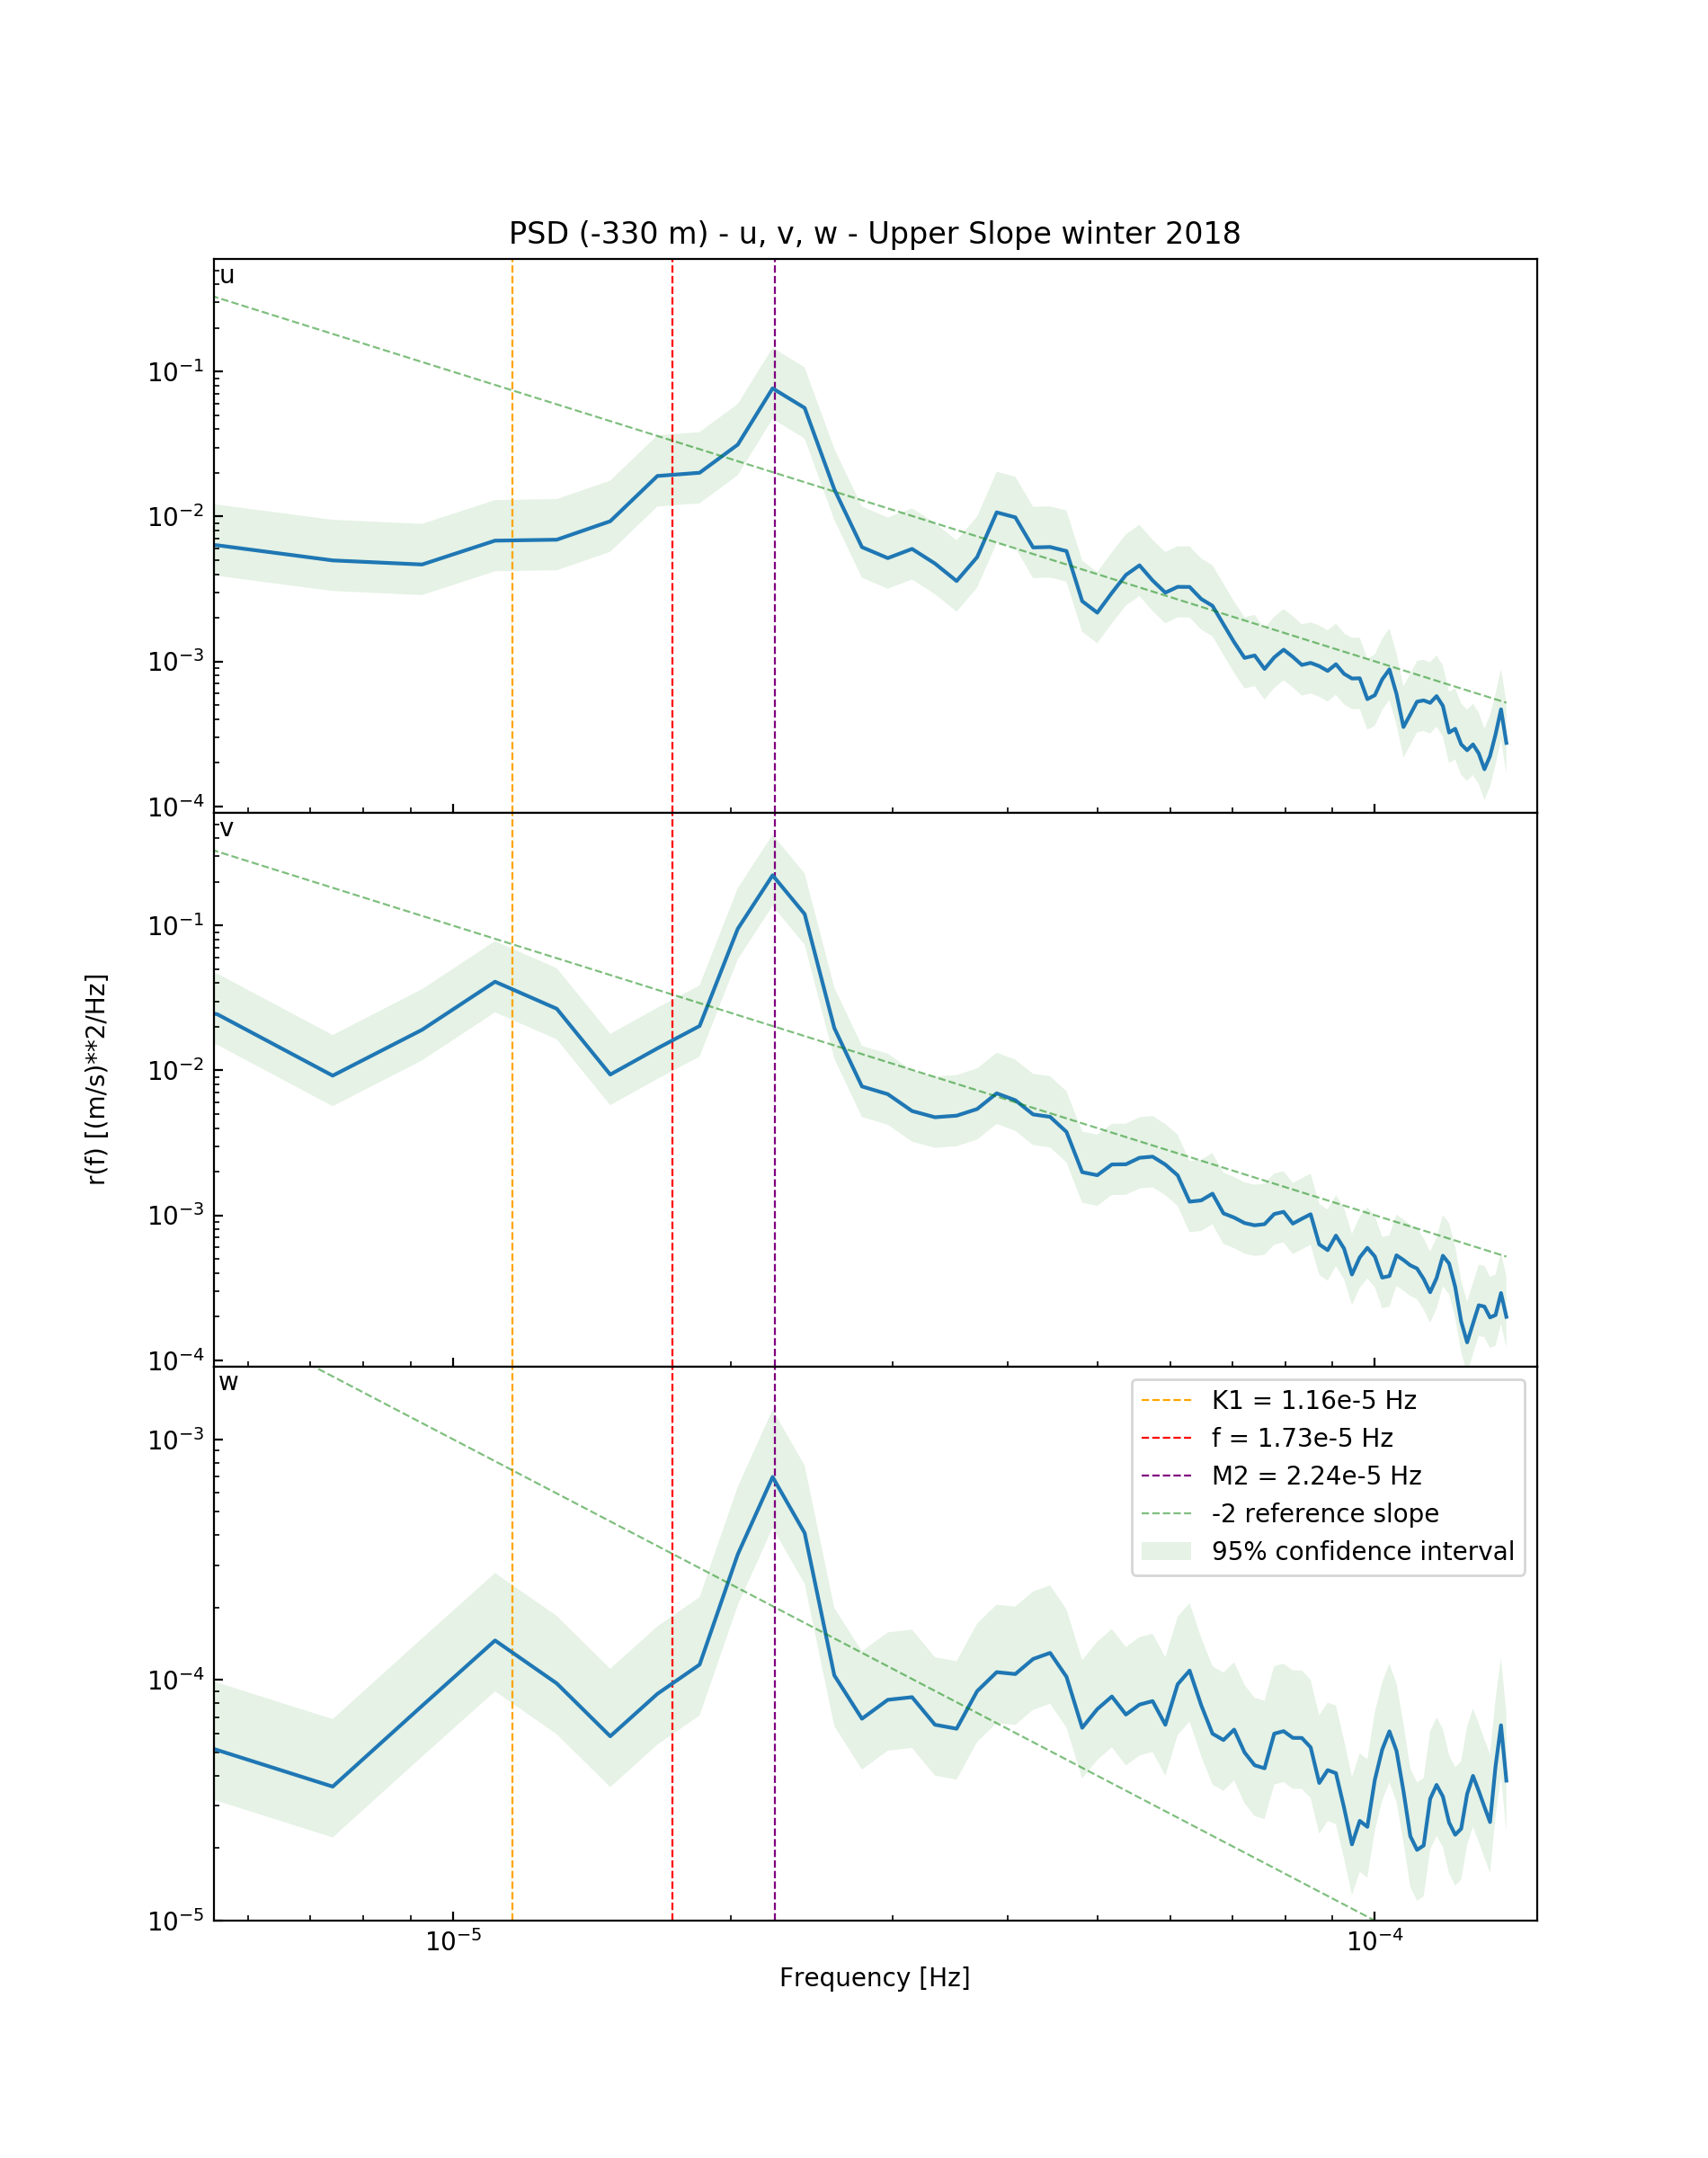

/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in power
/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in power
/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in power


In [14]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(9.5,12), sharex=True)
fig.subplots_adjust(hspace = 0.0)

ax1.axvline(1.161e-5, color ='orange',ls='--',lw=0.8,label = "K1 = 1.16e-5 Hz") # inertial period
ax1.axvline(1.732e-5, color ='red',ls='--', lw=0.8,label = "f = 1.73e-5 Hz")
ax1.axvline(2.236e-5, color ='purple',ls='--',lw=0.8,label = "M2 = 2.24e-5 Hz")
ax1.loglog(um6_f/3600, um6_PDS)
ax1.set_ylim(9e-5,6e-1)
ax1.set_xlim(5.5e-6,1.5e-4)
ax1.set_title('PSD (-330 m) - u, v, w - Upper Slope winter 2018')
ax1.tick_params(axis='both', direction='in', which='both')

ax2.axvline(1.161e-5, color ='orange',ls='--',lw=0.8,label = "K1 = 1.16e-5 Hz") # inertial period
ax2.axvline(1.732e-5, color ='red',ls='--', lw=0.8,label = "f = 1.73e-5 Hz")
ax2.axvline(2.236e-5, color ='purple',ls='--',lw=0.8,label = "M2 = 2.24e-5 Hz")
ax2.loglog(vm6_f/3600, vm6_PDS)
ax2.set_ylim(9e-5,6e-1)
ax2.tick_params(axis='both', direction='in', which='both')

ax3.axvline(1.161e-5, color ='orange',ls='--',lw=0.8,label = "K1 = 1.16e-5 Hz") # inertial period
ax3.axvline(1.732e-5, color ='red',ls='--', lw=0.8,label = "f = 1.73e-5 Hz")
ax3.axvline(2.236e-5, color ='purple',ls='--',lw=0.8,label = "M2 = 2.24e-5 Hz")
ax3.loglog(wm6_f/3600, wm6_PDS)
ax3.set_ylim(1e-5,2e-3)
ax3.set_xlabel('Frequency [Hz]')
ax3.tick_params(axis='both', direction='in', which='both')

fig.text(0.05, 0.5, 'r(f) [(m/s)**2/Hz]', va='center', rotation='vertical')
fig.text(0.128, 0.872, 'u', va='center')
fig.text(0.128, 0.616, 'v', va='center')
fig.text(0.128, 0.359, 'w', va='center')

ax1.fill_between(um6_f/3600, um6_lower, um6_upper, facecolor='green', alpha=0.1)
ax2.fill_between(vm6_f/3600, vm6_lower, vm6_upper, facecolor='green', alpha=0.1)
ax3.fill_between(wm6_f/3600, wm6_lower, wm6_upper, facecolor='green', alpha=0.1, label='95% confidence interval')

ax1.loglog(um6_f/3600,(10e-12)*(um6_f/3600)**(-2),color='green',lw=0.8,ls='--',alpha=0.5)
ax2.loglog(um6_f/3600,(10e-12)*(um6_f/3600)**(-2),color='green',lw=0.8,ls='--',alpha=0.5)
ax3.loglog(um6_f/3600,(10e-14)*(um6_f/3600)**(-2),color='green',lw=0.8,ls='--',alpha=0.5, label='-2 reference slope')

plt.legend(loc='upper right')
plt.show()

### Depth = -140 meters - Combined

In [15]:
um30 = uorig[:,30] - np.mean(uorig[:,30]) # depth[30] = ~140 meters
ulpm30 = ulp[:,30] - np.mean(ulp[:,30])
uhpm30 = uhp[:,30] - np.mean(uhp[:,30])

vm30 = vorig[:,30] - np.mean(vorig[:,30])
vlpm30 = vlp[:,30] - np.mean(vlp[:,30])
vhpm30 = vhp[:,30] - np.mean(vhp[:,30])

wm30 = worig[:,30] - np.mean(worig[:,30])
wlpm30 = wlp[:,30] - np.mean(wlp[:,30])
whpm30 = whp[:,30] - np.mean(whp[:,30])

In [16]:
#typically use 2**x for nperseg, up to sample size

fs_x = 1
window_x = 'parzen'
nperseg_x = 150        #1404 max

um30_f, um30_PDS = sig.welch(um30, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)
ulpm30_f, ulpm30_PDS = sig.welch(ulpm30, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)
uhpm30_f, uhpm30_PDS = sig.welch(uhpm30, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)

vm30_f, vm30_PDS = sig.welch(vm30, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)
vlpm30_f, vlpm30_PDS = sig.welch(vlpm30, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)
vhpm30_f, vhpm30_PDS = sig.welch(vhpm30, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)

wm30_f, wm30_PDS = sig.welch(wm30, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)
wlpm30_f, wlpm30_PDS = sig.welch(wlpm30, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)
whpm30_f, whpm30_PDS = sig.welch(whpm30, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)

In [17]:
# 95% confidence intervals

um30_lower = um30_PDS * cint[0]           # define upper and lower confidence values
um30_upper = um30_PDS * cint[1]
vm30_lower = vm30_PDS * cint[0]           # define upper and lower confidence values
vm30_upper = vm30_PDS * cint[1]
wm30_lower = wm30_PDS * cint[0]           # define upper and lower confidence values
wm30_upper = wm30_PDS * cint[1]

<IPython.core.display.Javascript object>


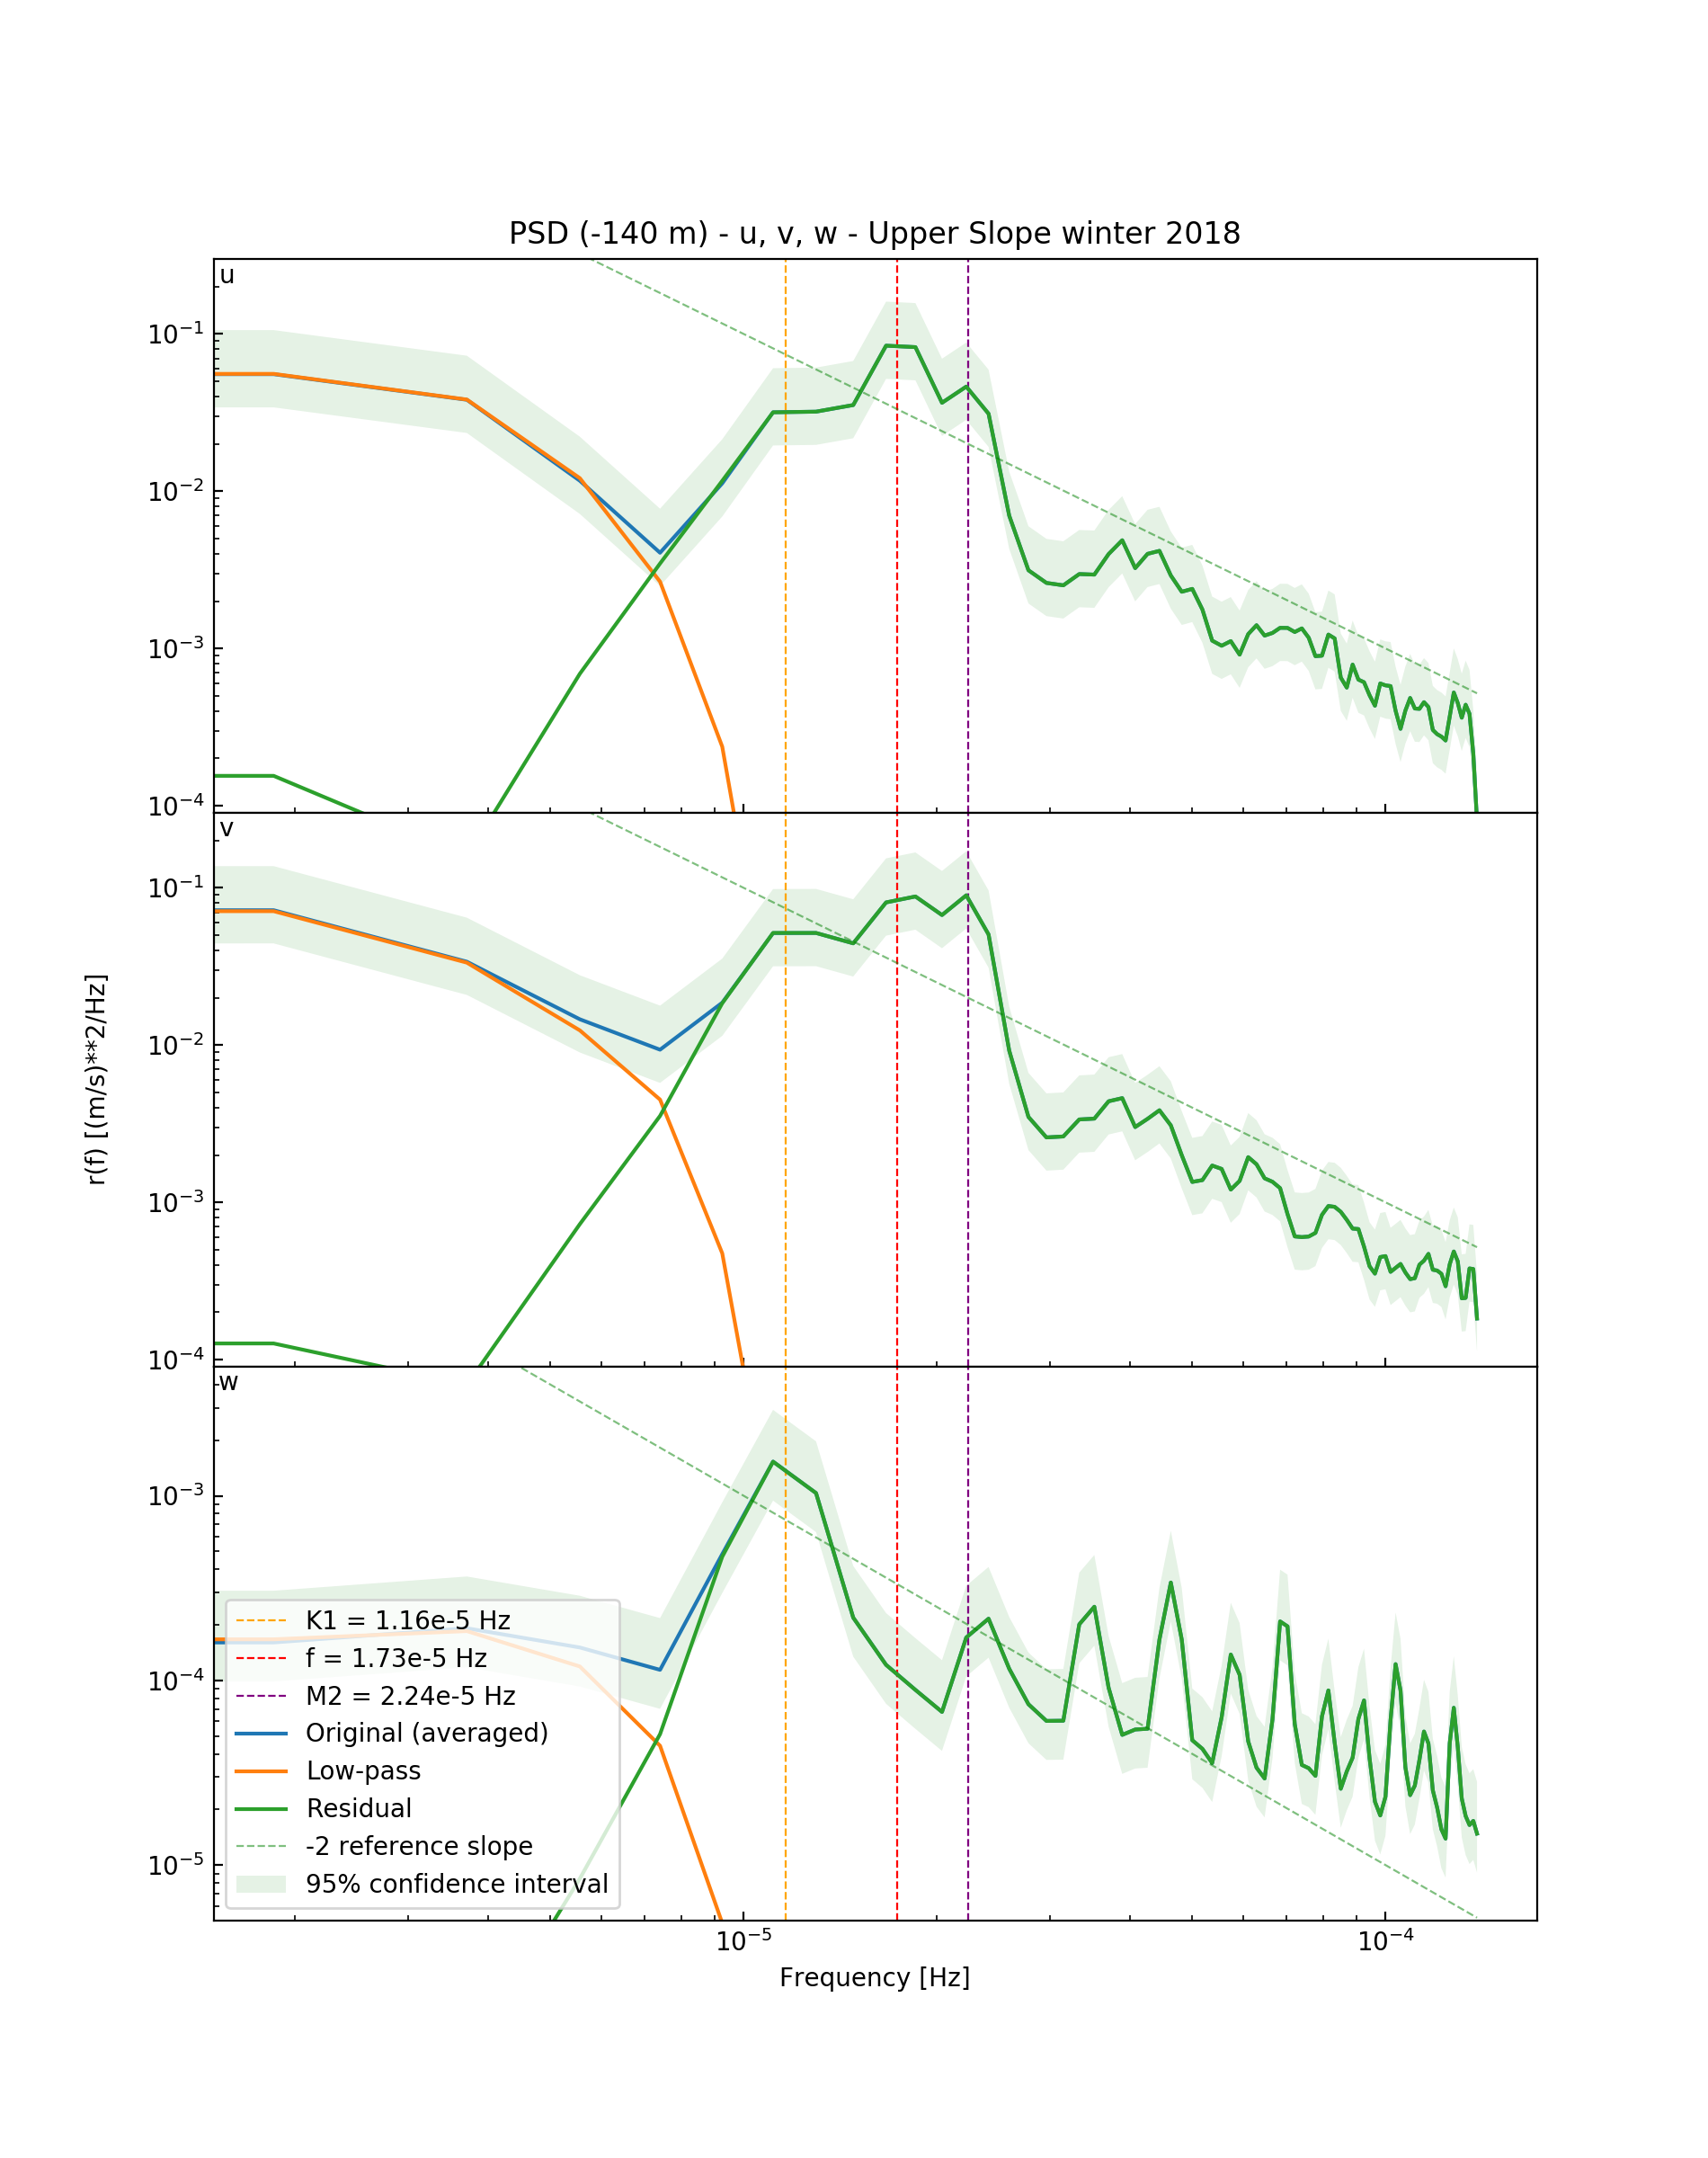

/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in power
/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in power
/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in power


In [18]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(9.5,12), sharex=True)
fig.subplots_adjust(hspace = 0.0)

ax1.axvline(1.161e-5, color ='orange',ls='--',lw=0.8,label = "K1 = 1.16e-5 Hz") # inertial period
ax1.axvline(1.732e-5, color ='red',ls='--', lw=0.8,label = "f = 1.73e-5 Hz")
ax1.axvline(2.236e-5, color ='purple',ls='--',lw=0.8,label = "M2 = 2.24e-5 Hz")
ax1.loglog(um30_f/3600, um30_PDS)
ax1.loglog(ulpm30_f/3600, ulpm30_PDS)
ax1.loglog(uhpm30_f/3600, uhpm30_PDS)
ax1.set_ylim(9e-5,3e-1)
ax1.tick_params(axis='both', direction='in', which='both')
ax1.set_title('PSD (-140 m) - u, v, w - Upper Slope winter 2018')

ax2.axvline(1.161e-5, color ='orange',ls='--',lw=0.8,label = "K1 = 1.16e-5 Hz")
ax2.axvline(1.732e-5, color ='red',ls='--', lw=0.8,label = "f = 1.73e-5 Hz")
ax2.axvline(2.236e-5, color ='purple',ls='--',lw=0.8,label = "M2 = 2.24e-5 Hz")
ax2.loglog(vm30_f/3600, vm30_PDS)
ax2.loglog(vlpm30_f/3600, vlpm30_PDS)
ax2.loglog(vhpm30_f/3600, vhpm30_PDS)
ax2.set_ylim(9e-5,3e-1)
ax2.tick_params(axis='both', direction='in', which='both')

ax3.axvline(1.161e-5, color ='orange',ls='--',lw=0.8,label = "K1 = 1.16e-5 Hz")
ax3.axvline(1.732e-5, color ='red',ls='--', lw=0.8,label = "f = 1.73e-5 Hz")
ax3.axvline(2.236e-5, color ='purple',ls='--',lw=0.8,label = "M2 = 2.24e-5 Hz")
ax3.loglog(wm30_f/3600, wm30_PDS, label='Original (averaged)')
ax3.loglog(wlpm30_f/3600, wlpm30_PDS, label='Low-pass')
ax3.loglog(whpm30_f/3600, whpm30_PDS, label='Residual')
ax3.set_ylim(5e-6,5e-3)
ax3.set_xlabel('Frequency [Hz]')
ax3.tick_params(axis='both', direction='in', which='both')

fig.text(0.05, 0.5, 'r(f) [(m/s)**2/Hz]', va='center', rotation='vertical')
fig.text(0.128, 0.872, 'u', va='center')
fig.text(0.128, 0.616, 'v', va='center')
fig.text(0.128, 0.359, 'w', va='center')

ax1.fill_between(um30_f/3600, um30_lower, um30_upper, facecolor='green', alpha=0.1)
ax2.fill_between(vm30_f/3600, vm30_lower, vm30_upper, facecolor='green', alpha=0.1)
ax3.fill_between(wm30_f/3600, wm30_lower, wm30_upper, facecolor='green', alpha=0.1, label='95% confidence interval')

ax1.loglog(um6_f/3600,(10e-12)*(um6_f/3600)**(-2),color='green',lw=0.8,ls='--',alpha=0.5)
ax2.loglog(um6_f/3600,(10e-12)*(um6_f/3600)**(-2),color='green',lw=0.8,ls='--',alpha=0.5)
ax3.loglog(um6_f/3600,(10e-14)*(um6_f/3600)**(-2),color='green',lw=0.8,ls='--',alpha=0.5, label='-2 reference slope')

plt.legend(loc='lower left')
plt.show()

### Depth = -140 meters - 'High' Frequency

<IPython.core.display.Javascript object>


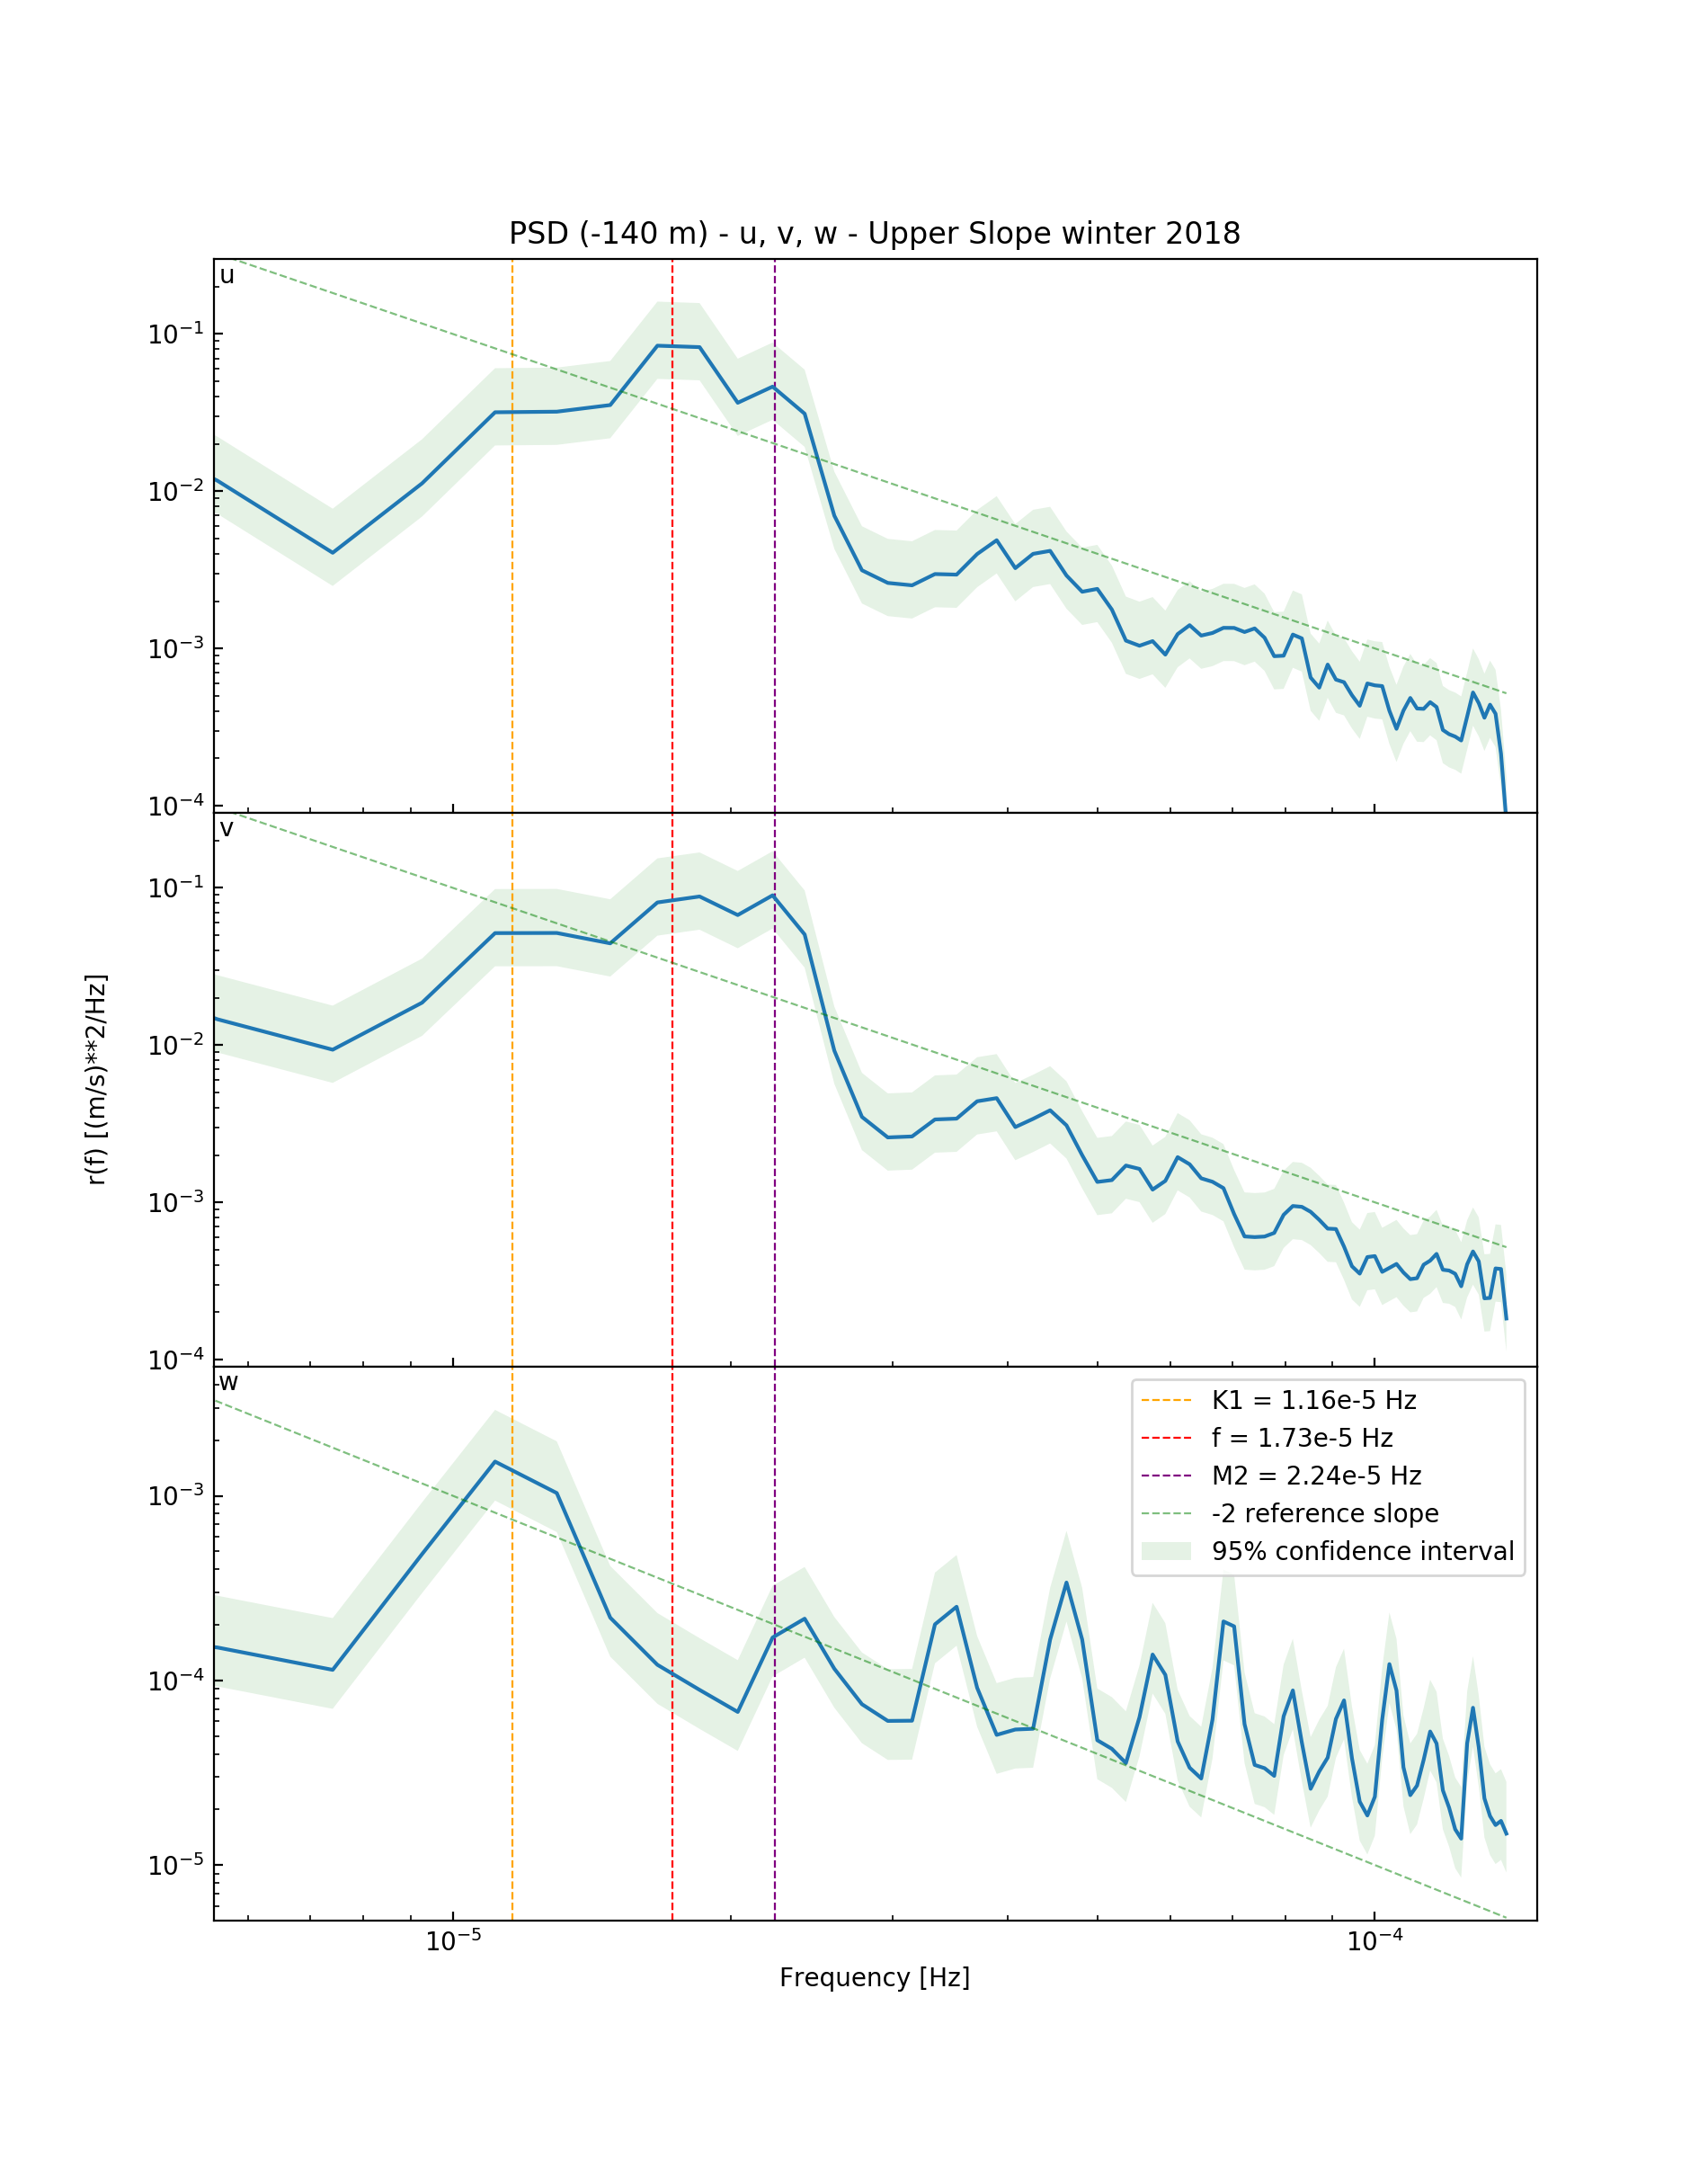

/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in power
/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in power
/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in power


In [19]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(9.5,12), sharex=True)
fig.subplots_adjust(hspace = 0.0)

ax1.axvline(1.161e-5, color ='orange',ls='--',lw=0.8,label = "K1 = 1.16e-5 Hz")
ax1.axvline(1.732e-5, color ='red',ls='--', lw=0.8,label = "f = 1.73e-5 Hz")
ax1.axvline(2.236e-5, color ='purple',ls='--',lw=0.8,label = "M2 = 2.24e-5 Hz")
ax1.loglog(um30_f/3600, um30_PDS)
ax1.set_ylim(9e-5,3e-1)
ax1.set_xlim(5.5e-6,1.5e-4)
ax1.tick_params(axis='both', direction='in', which='both')
ax1.set_title('PSD (-140 m) - u, v, w - Upper Slope winter 2018')

ax2.axvline(1.161e-5, color ='orange',ls='--',lw=0.8,label = "K1 = 1.16e-5 Hz")
ax2.axvline(1.732e-5, color ='red',ls='--', lw=0.8,label = "f = 1.73e-5 Hz")
ax2.axvline(2.236e-5, color ='purple',ls='--',lw=0.8,label = "M2 = 2.24e-5 Hz")
ax2.loglog(vm30_f/3600, vm30_PDS)
ax2.set_ylim(9e-5,3e-1)
ax2.tick_params(axis='both', direction='in', which='both')

ax3.axvline(1.161e-5, color ='orange',ls='--',lw=0.8,label = "K1 = 1.16e-5 Hz")
ax3.axvline(1.732e-5, color ='red',ls='--', lw=0.8,label = "f = 1.73e-5 Hz")
ax3.axvline(2.236e-5, color ='purple',ls='--',lw=0.8,label = "M2 = 2.24e-5 Hz")
ax3.loglog(wm30_f/3600, wm30_PDS)
ax3.set_ylim(5e-6,5e-3)
ax3.set_xlabel('Frequency [Hz]')
ax3.tick_params(axis='both', direction='in', which='both')

fig.text(0.05, 0.5, 'r(f) [(m/s)**2/Hz]', va='center', rotation='vertical')
fig.text(0.128, 0.872, 'u', va='center')
fig.text(0.128, 0.616, 'v', va='center')
fig.text(0.128, 0.359, 'w', va='center')

ax1.fill_between(um30_f/3600, um30_lower, um30_upper, facecolor='green', alpha=0.1)
ax2.fill_between(vm30_f/3600, vm30_lower, vm30_upper, facecolor='green', alpha=0.1)
ax3.fill_between(wm30_f/3600, wm30_lower, wm30_upper, facecolor='green', alpha=0.1, label='95% confidence interval')

ax1.loglog(um6_f/3600,(10e-12)*(um6_f/3600)**(-2),color='green',lw=0.8,ls='--',alpha=0.5)
ax2.loglog(um6_f/3600,(10e-12)*(um6_f/3600)**(-2),color='green',lw=0.8,ls='--',alpha=0.5)
ax3.loglog(um6_f/3600,(10e-14)*(um6_f/3600)**(-2),color='green',lw=0.8,ls='--',alpha=0.5, label='-2 reference slope')

plt.legend(loc='upper right')
plt.show()

### Comparitive Spectra

<IPython.core.display.Javascript object>


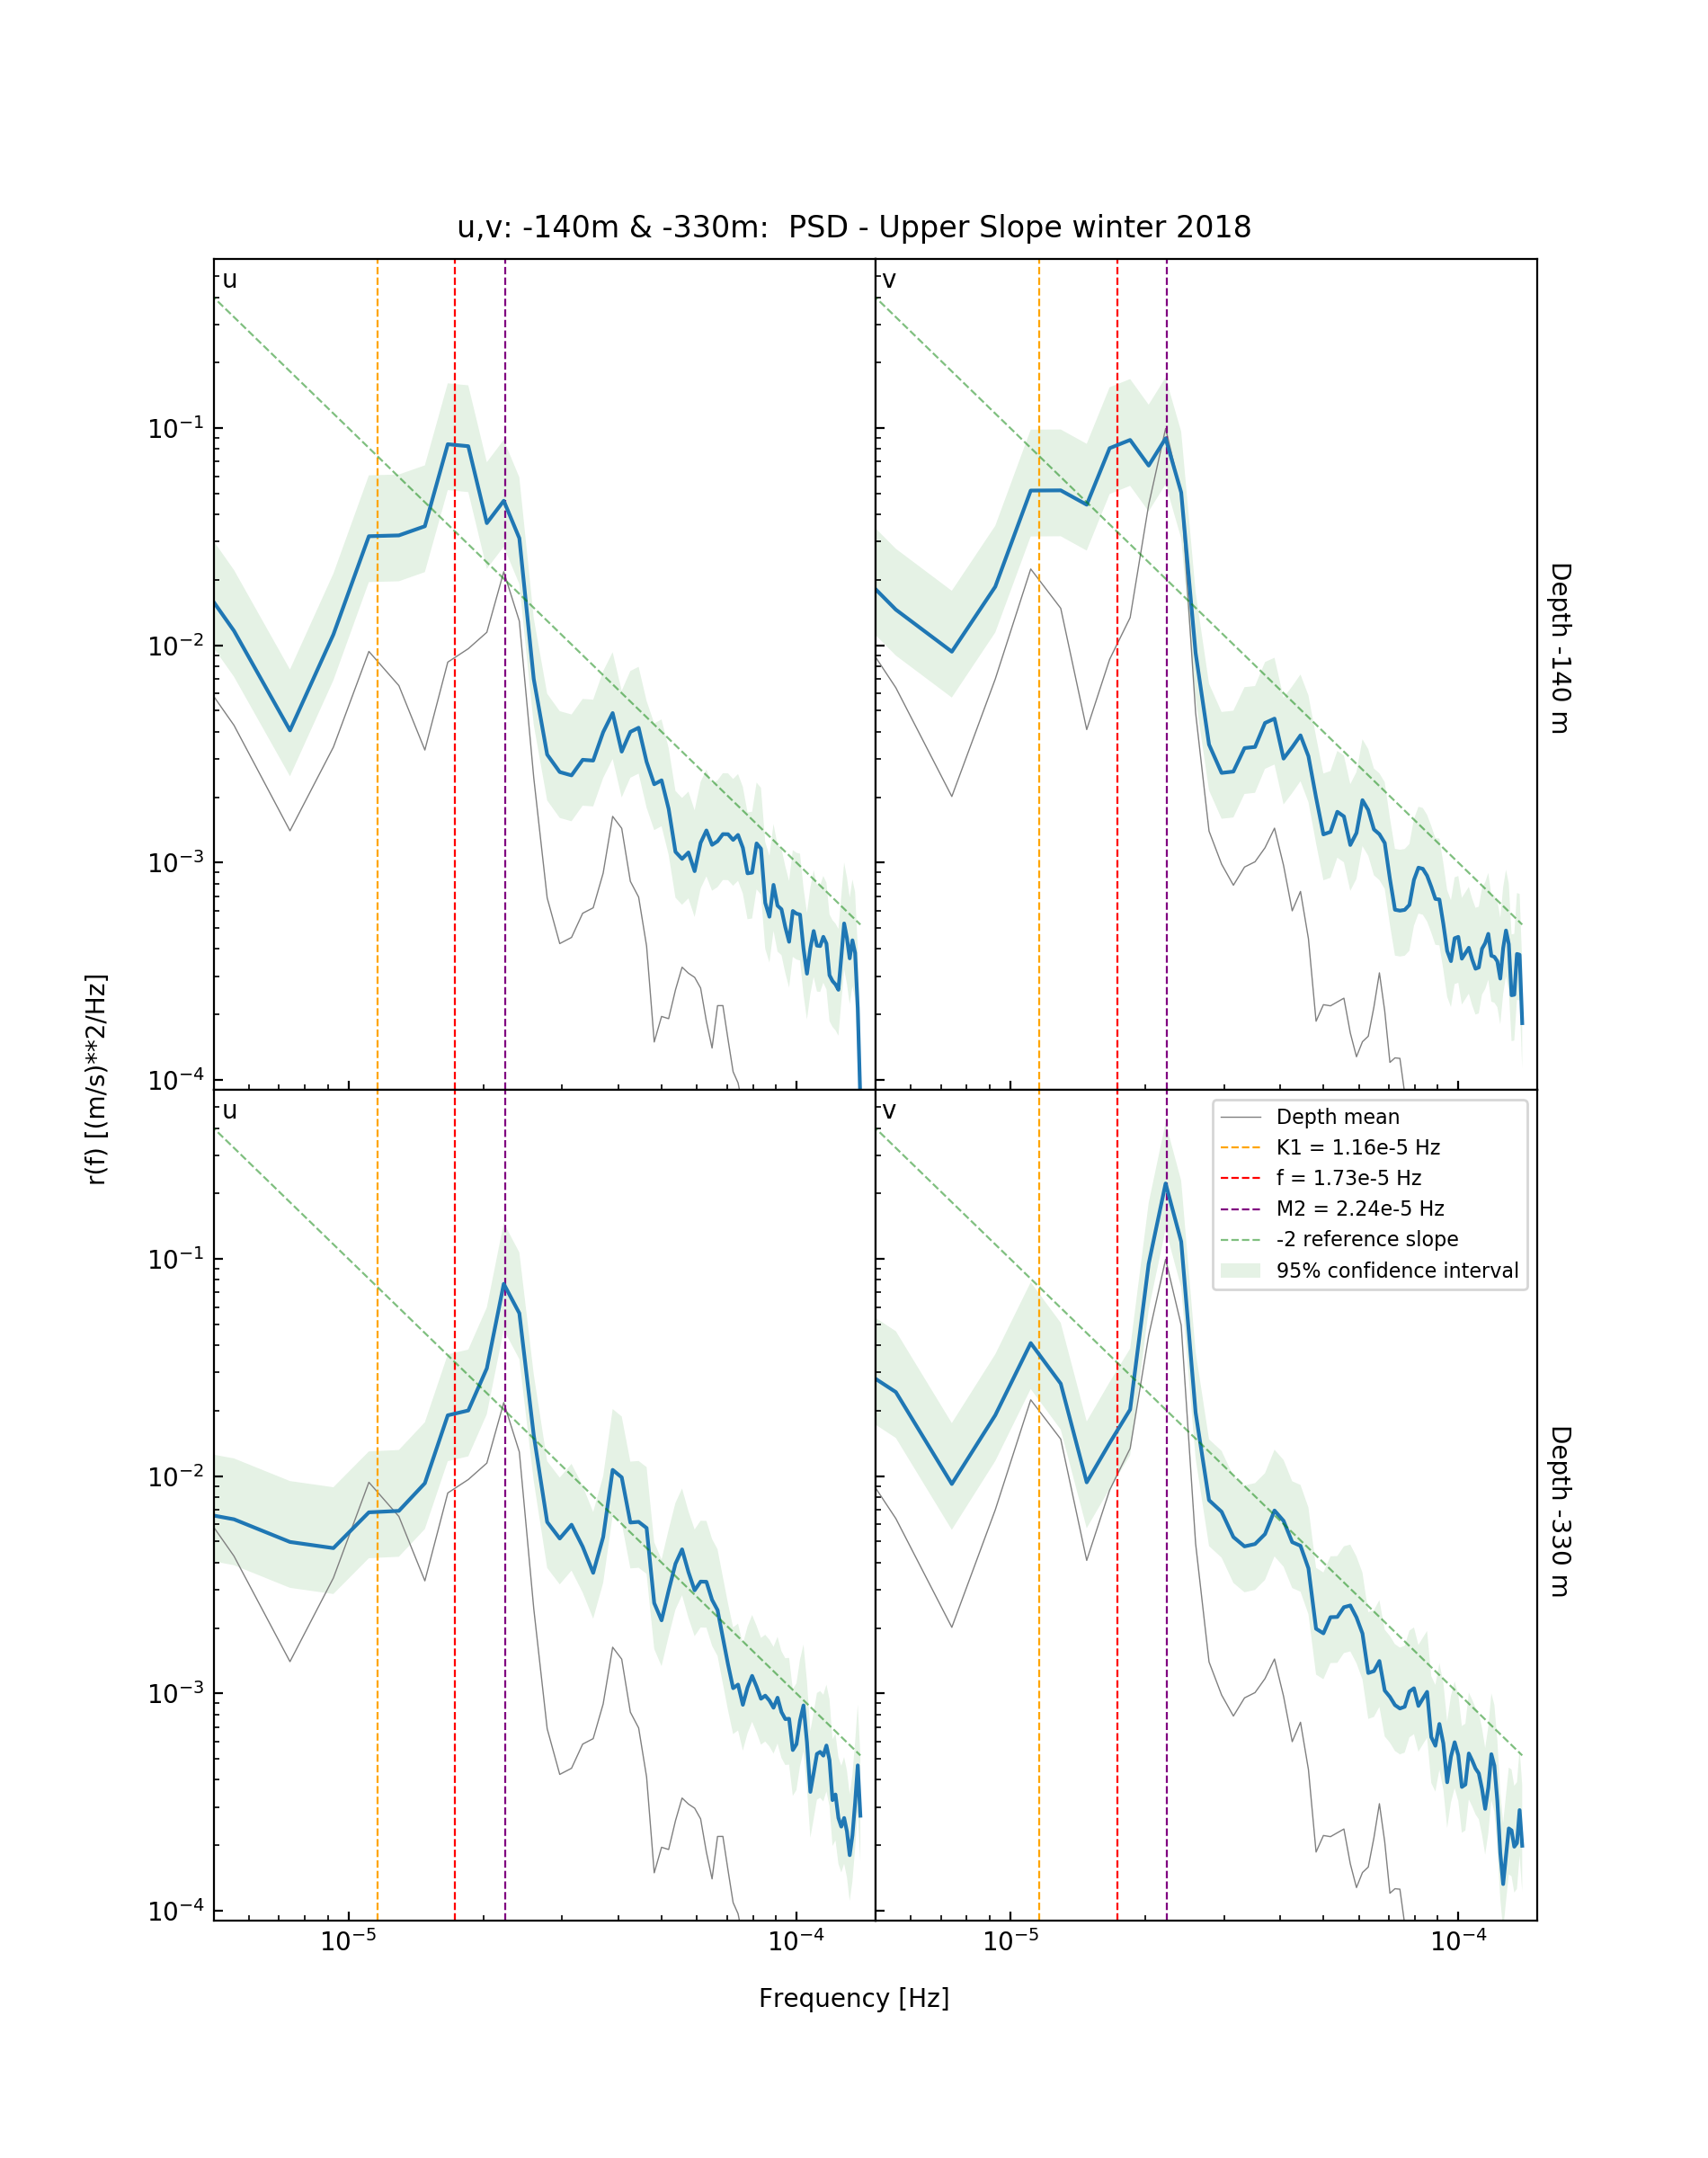

/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in power
/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in power
/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in power
/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in power


In [20]:
fig, axs = plt.subplots(2,2,figsize=(9.5,12), sharex=True, sharey=True)
(ax1,ax2),(ax3,ax4) = axs
fig.subplots_adjust(hspace=0, wspace=0)

ax1.loglog(um_depth_f/3600,um_depth_PDS,color='gray',lw=0.5)
ax2.loglog(vm_depth_f/3600,vm_depth_PDS,color='gray',lw=0.5)
ax3.loglog(um_depth_f/3600,um_depth_PDS,color='gray',lw=0.5)
ax4.loglog(vm_depth_f/3600,vm_depth_PDS,color='gray',lw=0.5,label='Depth mean')

ax1.axvline(1.161e-5, color ='orange',ls='--',lw=0.8,label = "K1 = 1.16e-5 Hz")
ax1.axvline(1.732e-5, color ='red',ls='--', lw=0.8,label = "f = 1.73e-5 Hz")
ax1.axvline(2.236e-5, color ='purple',ls='--',lw=0.8,label = "M2 = 2.24e-5 Hz")
ax1.loglog(um30_f/3600, um30_PDS)
ax1.tick_params(axis='both', direction='in', which='both')
ax1.set_ylim(9e-5,6e-1)
ax1.set_xlim(5e-6,1.5e-4)

ax2.axvline(1.161e-5, color ='orange',ls='--',lw=0.8,label = "K1 = 1.16e-5 Hz")
ax2.axvline(1.732e-5, color ='red',ls='--', lw=0.8,label = "f = 1.73e-5 Hz")
ax2.axvline(2.236e-5, color ='purple',ls='--',lw=0.8,label = "M2 = 2.24e-5 Hz")
ax2.tick_params(axis='both', direction='in', which='both')
ax2.loglog(vm30_f/3600, vm30_PDS)

ax3.axvline(1.161e-5, color ='orange',ls='--',lw=0.8,label = "K1 = 1.16e-5 Hz")
ax3.axvline(1.732e-5, color ='red',ls='--', lw=0.8,label = "f = 1.73e-5 Hz")
ax3.axvline(2.236e-5, color ='purple',ls='--',lw=0.8,label = "M2 = 2.24e-5 Hz")
ax3.tick_params(axis='both', direction='in', which='both')
ax3.loglog(um6_f/3600, um6_PDS)

ax4.axvline(1.161e-5, color ='orange',ls='--',lw=0.8,label = "K1 = 1.16e-5 Hz")
ax4.axvline(1.732e-5, color ='red',ls='--', lw=0.8,label = "f = 1.73e-5 Hz")
ax4.axvline(2.236e-5, color ='purple',ls='--',lw=0.8,label = "M2 = 2.24e-5 Hz")
ax4.tick_params(axis='both', direction='in', which='both')
ax4.loglog(vm6_f/3600, vm6_PDS)

fig.text(0.905, 0.7, 'Depth -140 m', va='center',rotation='270')
fig.text(0.905, 0.3, 'Depth -330 m', va='center',rotation='270')
fig.text(0.13, 0.87, 'u', va='center')
fig.text(0.13, 0.485, 'u', va='center')
fig.text(0.516, 0.87, 'v', va='center')
fig.text(0.516, 0.485, 'v', va='center')
fig.text(0.5,0.89,'u,v: -140m & -330m:  PSD - Upper Slope winter 2018', ha='center', fontsize=12)
fig.text(0.05, 0.5, 'r(f) [(m/s)**2/Hz]', va='center', rotation='vertical')
fig.text(0.5,0.07,'Frequency [Hz]',ha='center')

ax1.fill_between(um30_f/3600, um30_lower, um30_upper, facecolor='green', alpha=0.1)
ax2.fill_between(vm30_f/3600, vm30_lower, vm30_upper, facecolor='green', alpha=0.1)
ax3.fill_between(um6_f/3600, um6_lower, um6_upper, facecolor='green', alpha=0.1)
ax4.fill_between(vm6_f/3600, vm6_lower, vm6_upper, facecolor='green', alpha=0.1, label='95% confidence interval')

ax1.loglog(um6_f/3600,(10e-12)*(um6_f/3600)**(-2),color='green',lw=0.8,ls='--',alpha=0.5)
ax2.loglog(um6_f/3600,(10e-12)*(um6_f/3600)**(-2),color='green',lw=0.8,ls='--',alpha=0.5)
ax3.loglog(um6_f/3600,(10e-12)*(um6_f/3600)**(-2),color='green',lw=0.8,ls='--',alpha=0.5)
ax4.loglog(um6_f/3600,(10e-12)*(um6_f/3600)**(-2),color='green',lw=0.8,ls='--',alpha=0.5, label='-2 reference slope')

plt.legend(loc='upper right', fontsize=8)
plt.show()

<IPython.core.display.Javascript object>


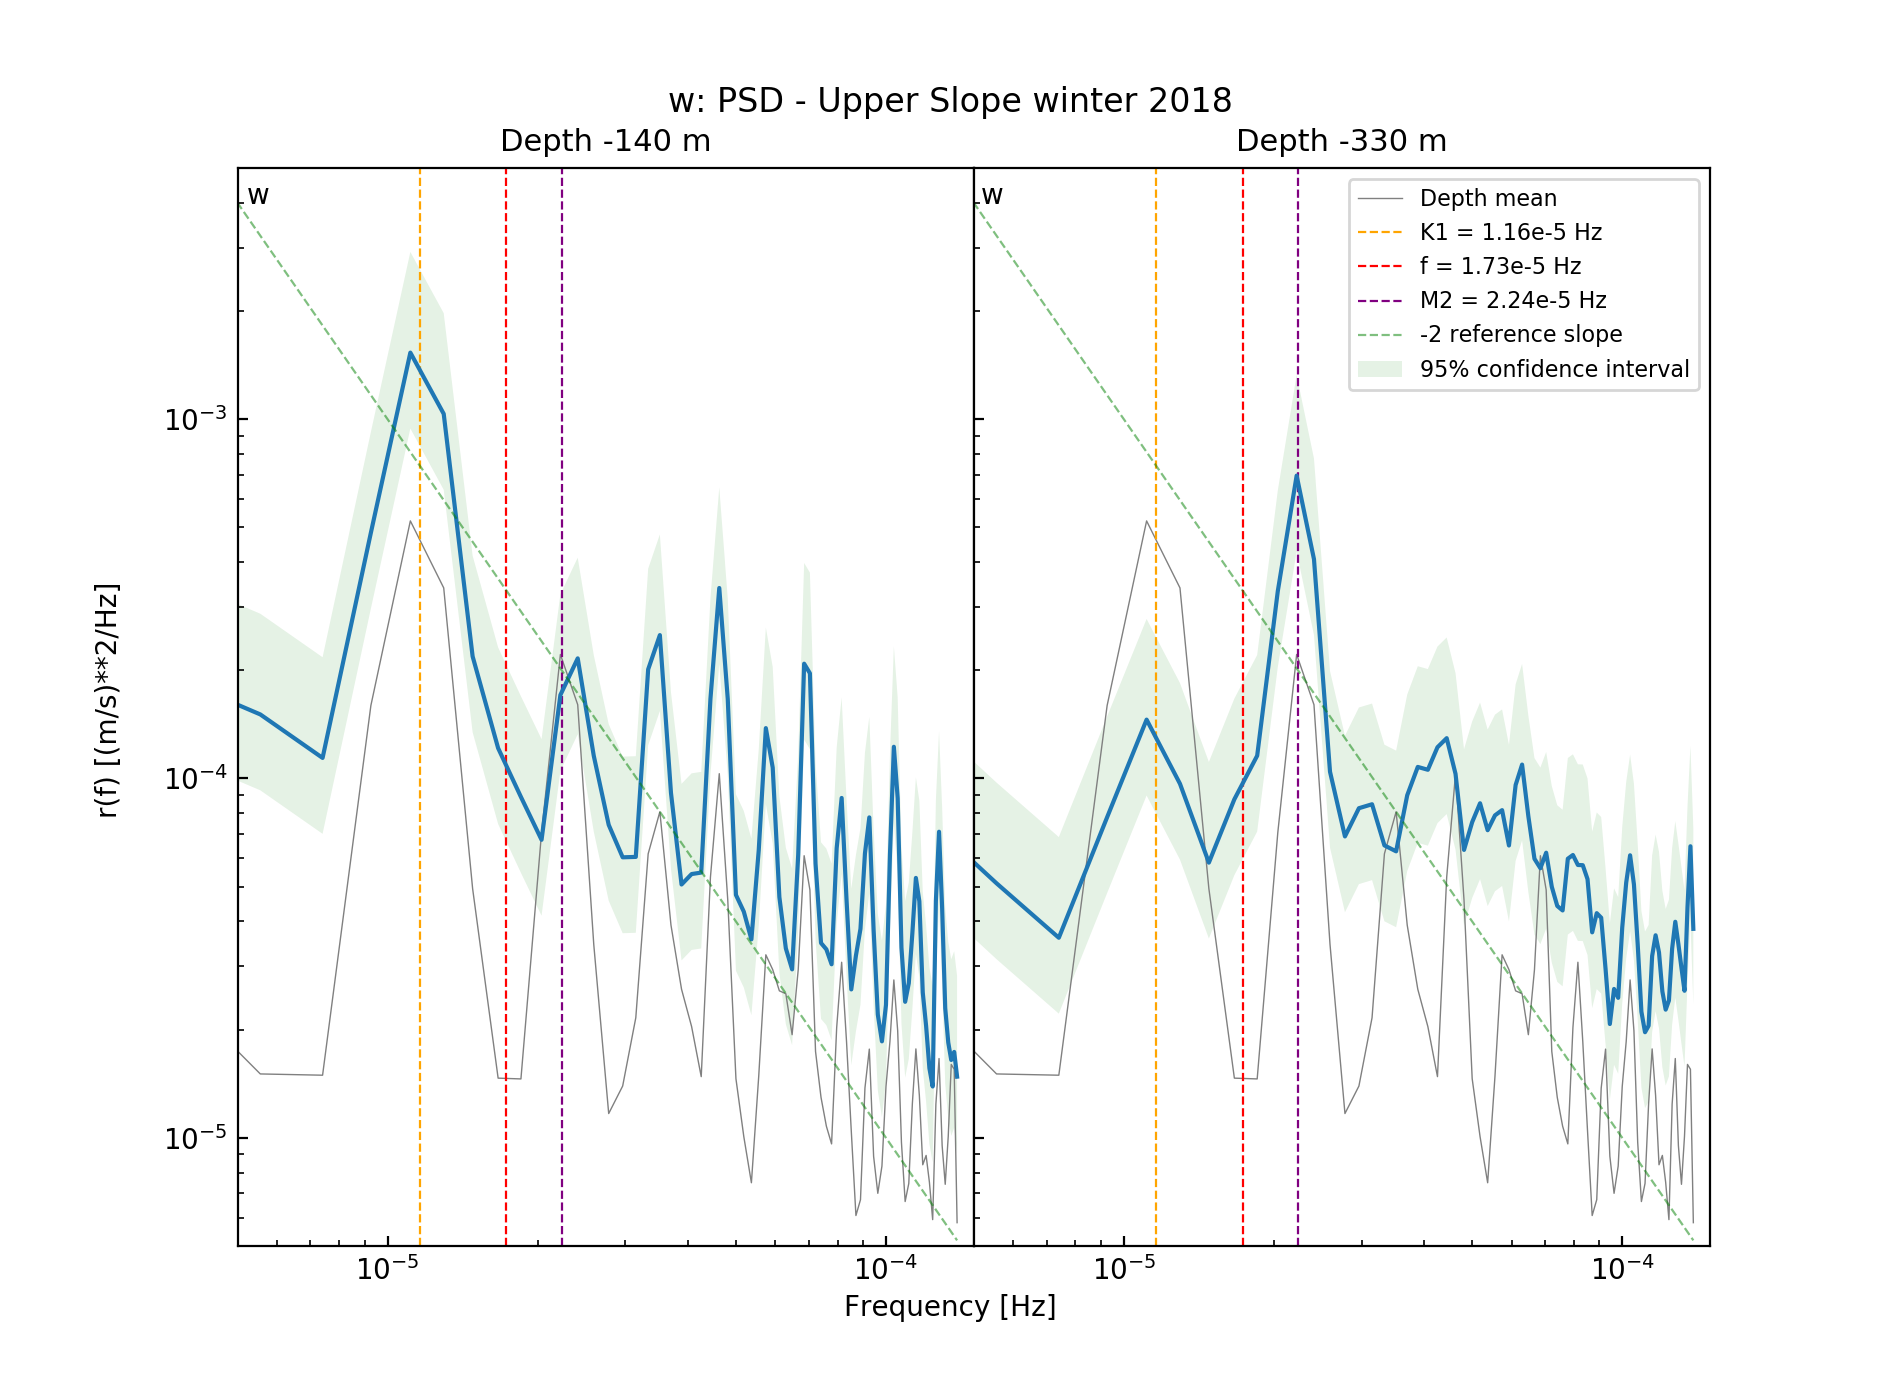

/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in power
/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in power


In [21]:
fig, axs = plt.subplots(1,2,figsize=(9.5,7), sharex=True, sharey=True)
(ax1,ax2) = axs
fig.subplots_adjust(hspace=0, wspace=0)

ax1.loglog(wm_depth_f/3600,wm_depth_PDS,color='gray',lw=0.5)
ax2.loglog(wm_depth_f/3600,wm_depth_PDS,color='gray',lw=0.5,label='Depth mean')

ax1.axvline(1.161e-5, color ='orange',ls='--',lw=0.8,label = "K1 = 1.16e-5 Hz")
ax1.axvline(1.732e-5, color ='red',ls='--', lw=0.8,label = "f = 1.73e-5 Hz")
ax1.axvline(2.236e-5, color ='purple',ls='--',lw=0.8,label = "M2 = 2.24e-5 Hz")
ax1.tick_params(axis='both', direction='in', which='both')
ax1.loglog(wm30_f/3600, wm30_PDS)
ax1.set_ylim(5e-6,5e-3)
ax1.set_xlim(5e-6,1.5e-4)
ax1.set_title('Depth -140 m', fontsize=11)

ax2.axvline(1.161e-5, color ='orange',ls='--',lw=0.8,label = "K1 = 1.16e-5 Hz")
ax2.axvline(1.732e-5, color ='red',ls='--', lw=0.8,label = "f = 1.73e-5 Hz")
ax2.axvline(2.236e-5, color ='purple',ls='--',lw=0.8,label = "M2 = 2.24e-5 Hz")
ax2.tick_params(axis='both', direction='in', which='both')
ax2.loglog(wm6_f/3600, wm6_PDS)
ax2.set_title('Depth -330 m', fontsize=11)

fig.text(0.13, 0.86, 'w', va='center')
fig.text(0.516, 0.86, 'w', va='center')
fig.text(0.5,0.92,'w: PSD - Upper Slope winter 2018', ha='center', fontsize=12)
fig.text(0.05, 0.5, 'r(f) [(m/s)**2/Hz]', va='center', rotation='vertical')
fig.text(0.5,0.06,'Frequency [Hz]',ha='center')

ax1.fill_between(wm30_f/3600, wm30_lower, wm30_upper, facecolor='green', alpha=0.1)
ax2.fill_between(wm6_f/3600, wm6_lower, wm6_upper, facecolor='green', alpha=0.1, label='95% confidence interval')

ax1.loglog(um6_f/3600,(10e-14)*(um6_f/3600)**(-2),color='green',lw=0.8,ls='--',alpha=0.5)
ax2.loglog(um6_f/3600,(10e-14)*(um6_f/3600)**(-2),color='green',lw=0.8,ls='--',alpha=0.5,label='-2 reference slope')

plt.legend(loc='upper right',fontsize=8)
plt.show()

## Velocities

**Plots for u, v, w (original, filtered, and residual) data**

<IPython.core.display.Javascript object>


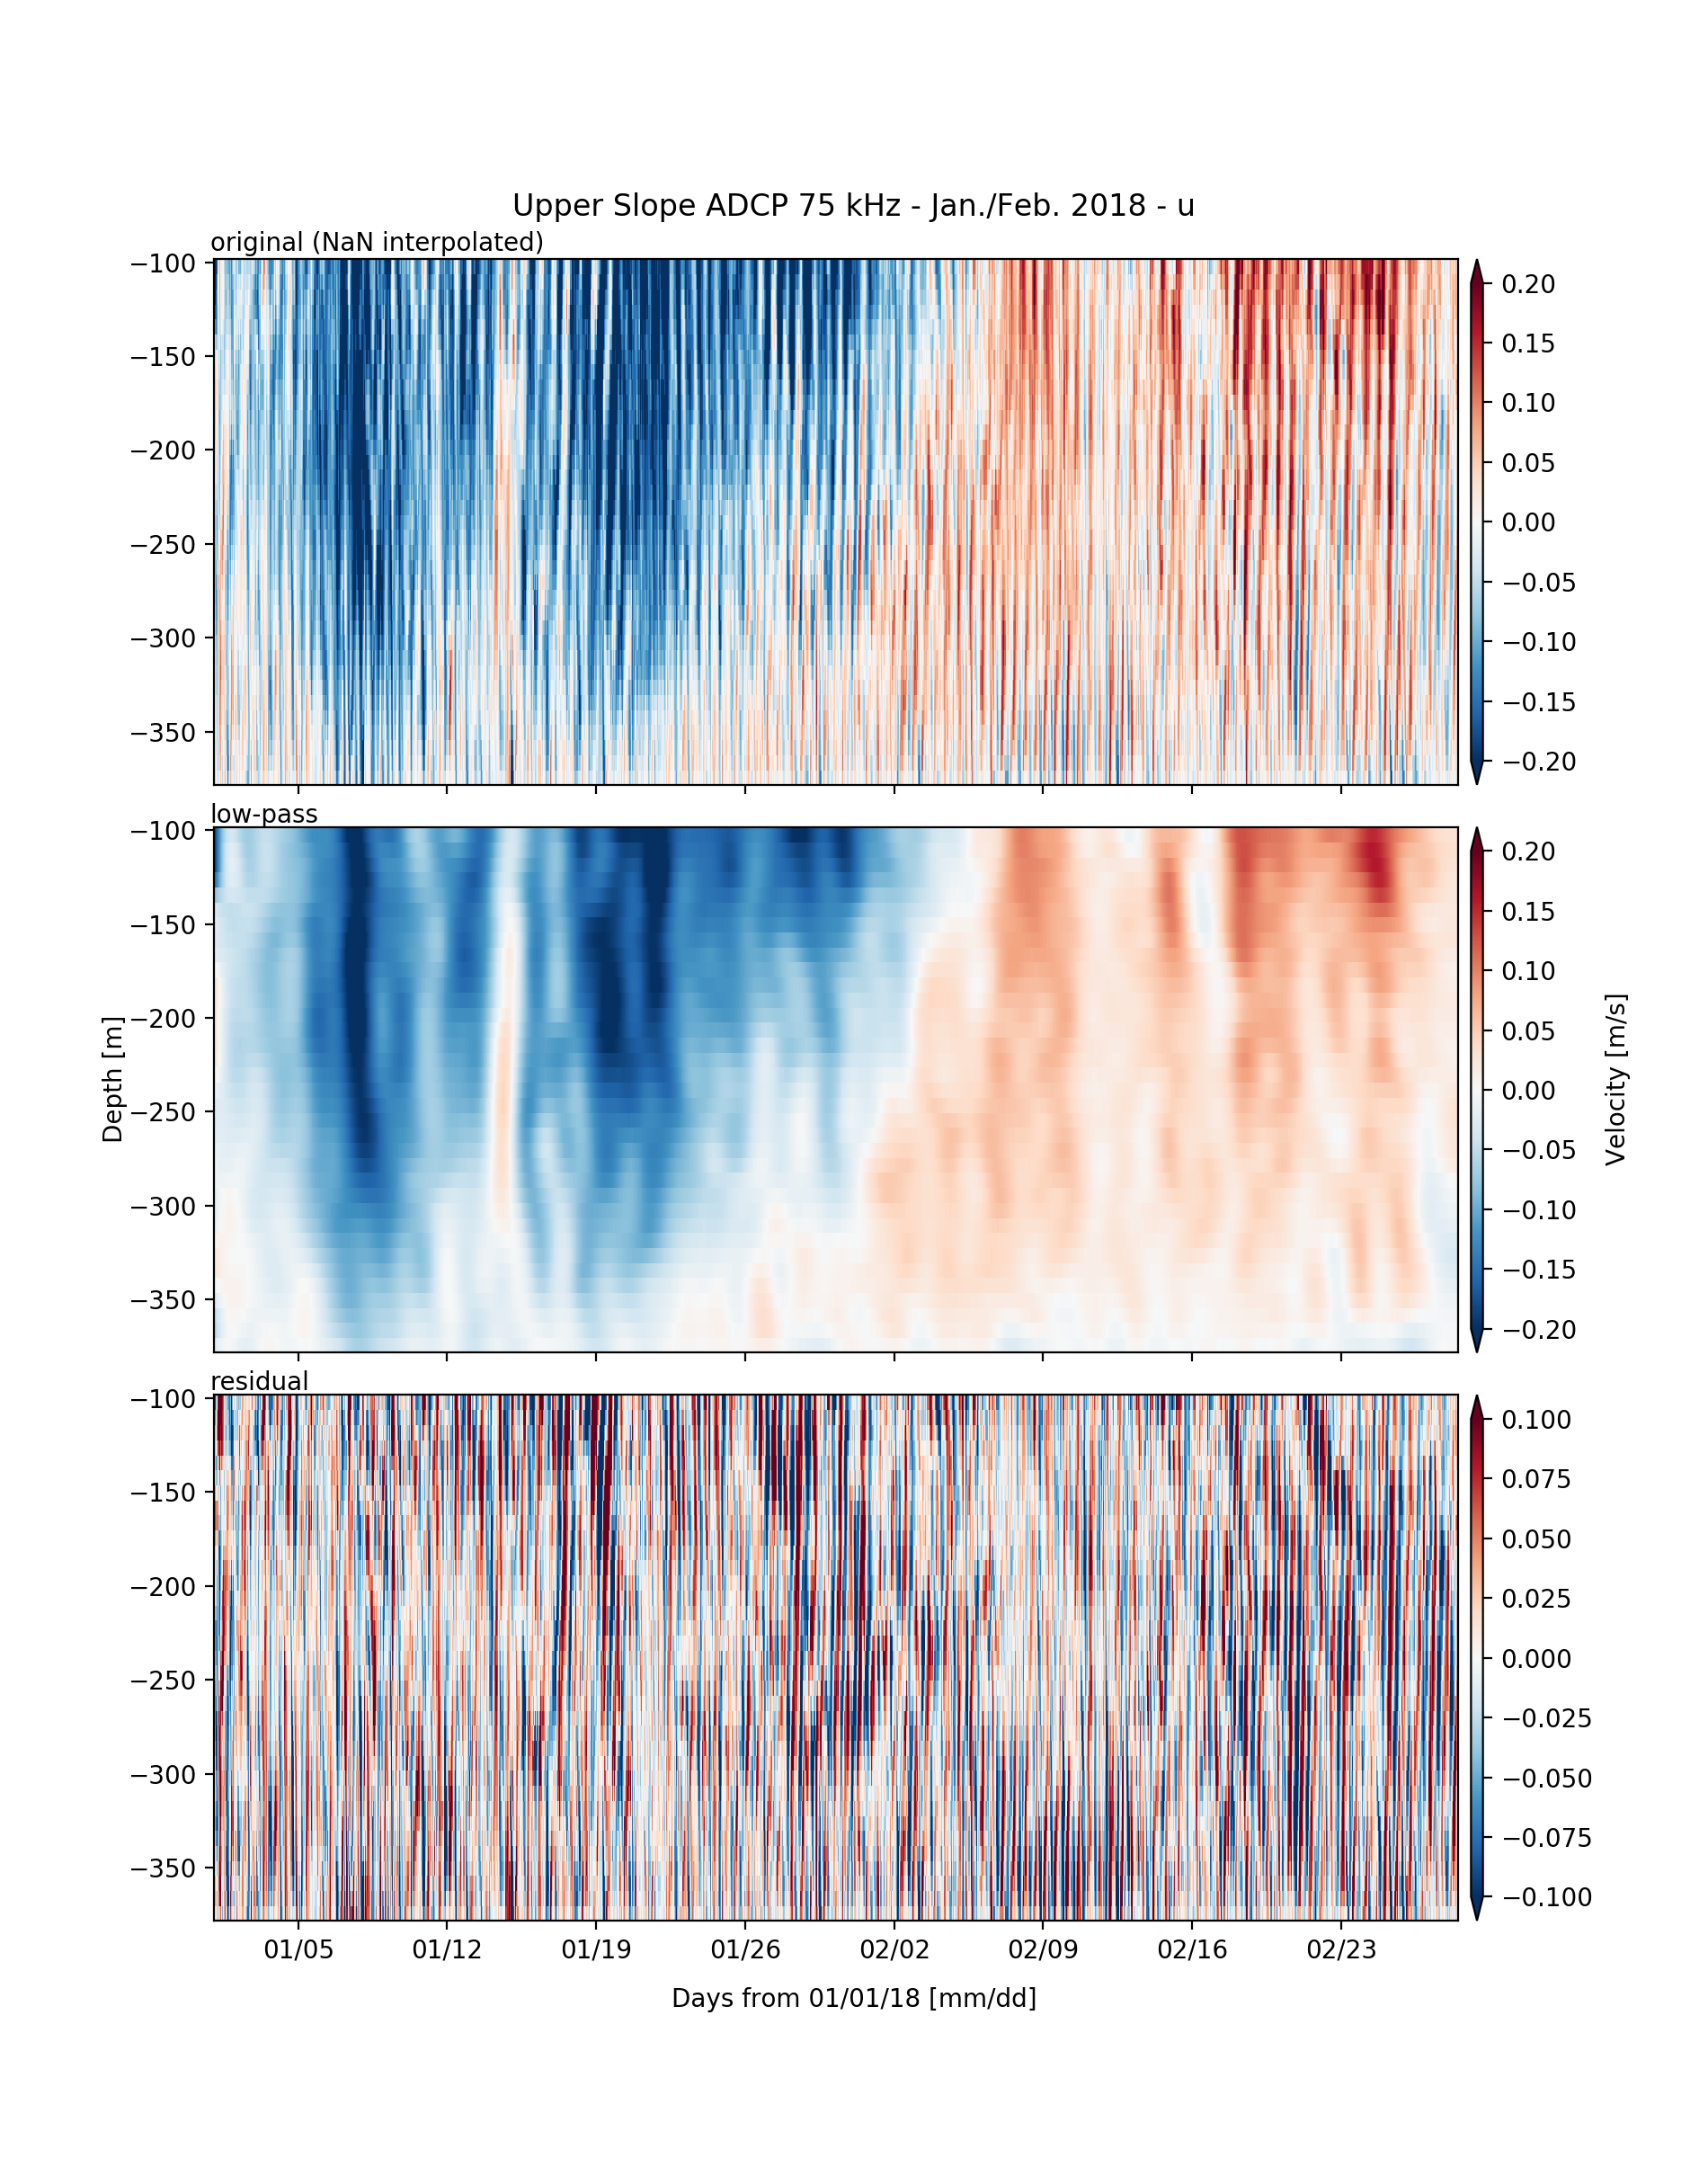

In [22]:
# plot u data

fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(9.5,12), sharex = True)
fig.subplots_adjust(hspace = 0.08)
fig.text(0.5, 0.9, 'Upper Slope ADCP 75 kHz - Jan./Feb. 2018 - u', ha='center', fontsize=12)
fig.text(0.06, 0.5, 'Depth [m]', va='center', rotation='vertical')
fig.text(0.123, 0.887, 'original (NaN interpolated)', va='center')
fig.text(0.123, 0.622, 'low-pass', va='center')
fig.text(0.123, 0.359, 'residual', va='center')
fig.text(0.94, 0.5, 'Velocity [m/s]', va='center', rotation='vertical')
fig.text(0.5, 0.07, 'Days from 01/01/18 [mm/dd]', ha='center')

im1 = ax1.pcolormesh(ds.time, -depth, uorig.T, rasterized=True, cmap='RdBu_r', vmin=-0.20, vmax=0.20)
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=40, extend='both')

im2 = ax2.pcolormesh(ds.time, -depth, ulp.T, rasterized=True, cmap='RdBu_r', vmin=-0.20, vmax=0.20)
cbar2 = fig.colorbar(im2, ax=ax2, fraction=0.05, pad=0.01, aspect=40, extend='both')

im3 = ax3.pcolormesh(ds.time, -depth, uhp.T, rasterized=True, cmap='RdBu_r', vmin=-0.10, vmax=0.10)
cbar3 = fig.colorbar(im3, ax=ax3, fraction=0.05, pad=0.01, aspect=40, extend='both')

date_form = pldates.DateFormatter("%m/%d")
ax3.xaxis.set_major_formatter(date_form)

XXX

<IPython.core.display.Javascript object>


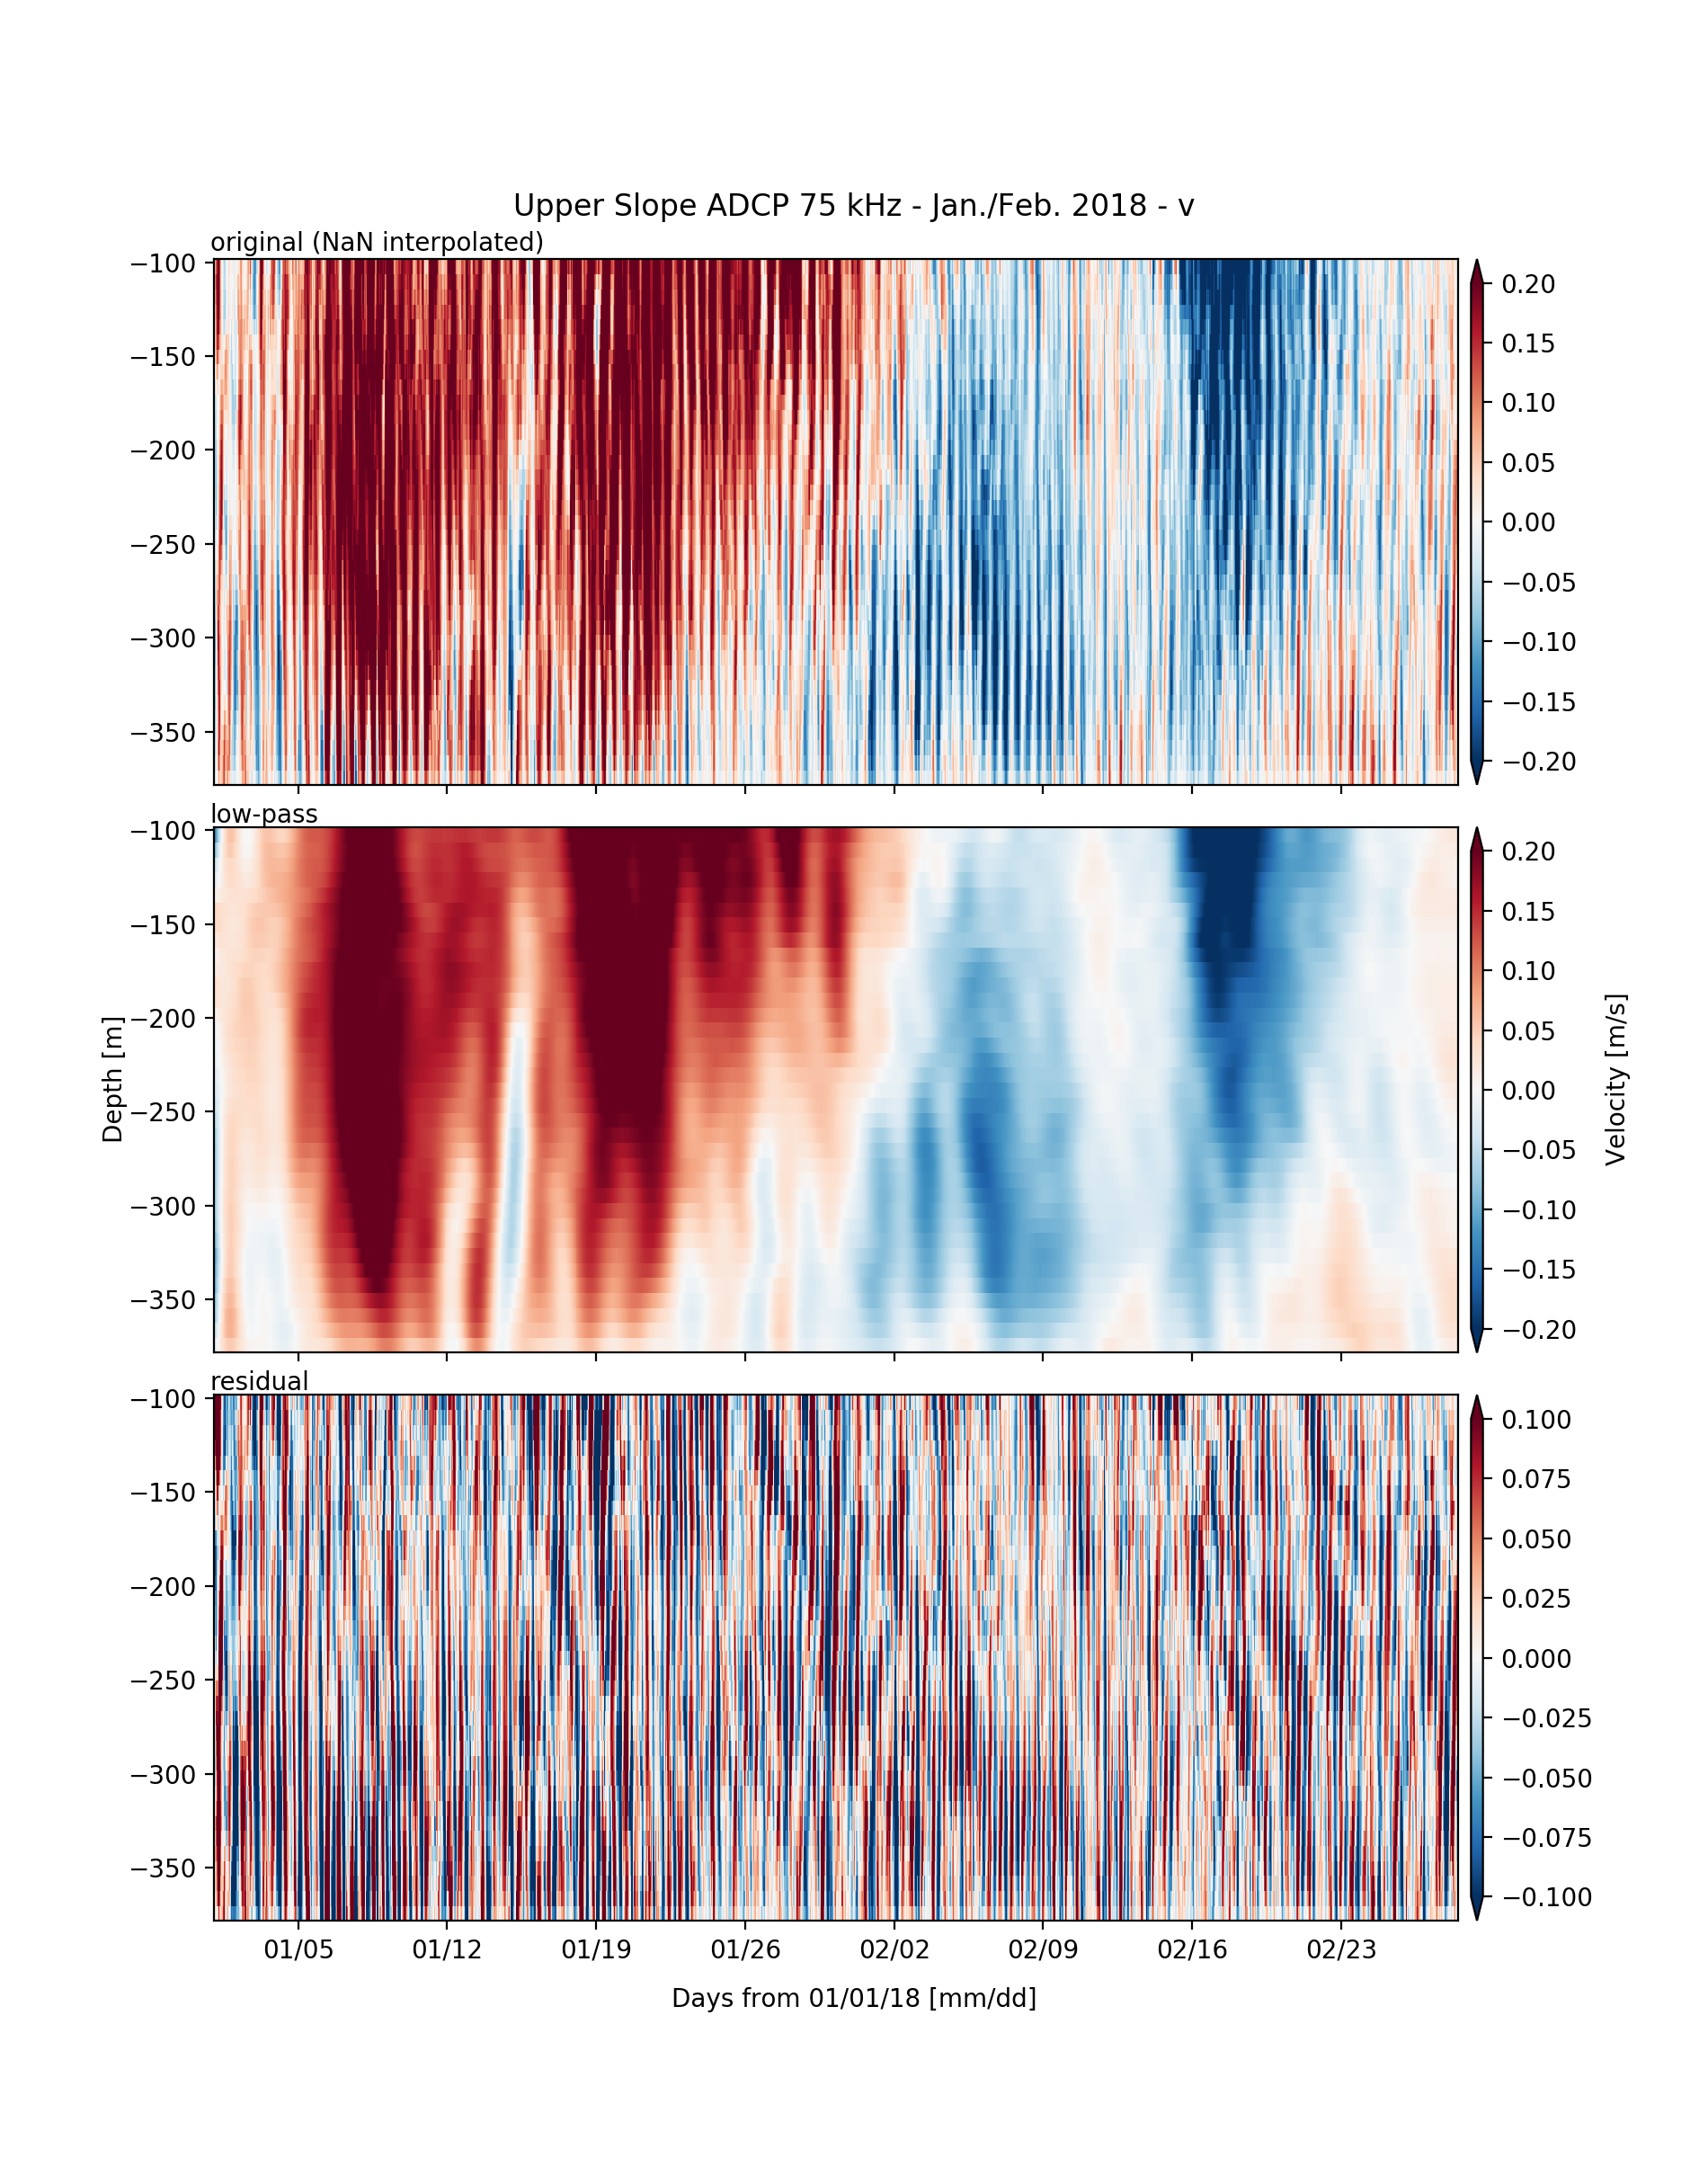

In [23]:
# plot v data

fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(9.5,12), sharex = True)
fig.subplots_adjust(hspace = 0.08)
fig.text(0.5, 0.9, 'Upper Slope ADCP 75 kHz - Jan./Feb. 2018 - v', ha='center', fontsize=12)
fig.text(0.06, 0.5, 'Depth [m]', va='center', rotation='vertical')
fig.text(0.123, 0.887, 'original (NaN interpolated)', va='center')
fig.text(0.123, 0.622, 'low-pass', va='center')
fig.text(0.123, 0.359, 'residual', va='center')
fig.text(0.94, 0.5, 'Velocity [m/s]', va='center', rotation='vertical')
fig.text(0.5, 0.07, 'Days from 01/01/18 [mm/dd]', ha='center')

im1 = ax1.pcolormesh(ds.time, -depth, vorig.T, rasterized=True, cmap='RdBu_r', vmin=-0.2, vmax=0.2)
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=40, extend='both')

im2 = ax2.pcolormesh(ds.time, -depth, vlp.T, rasterized=True, cmap='RdBu_r', vmin=-0.2, vmax=0.2)
cbar2 = fig.colorbar(im2, ax=ax2, fraction=0.05, pad=0.01, aspect=40, extend='both')

im3 = ax3.pcolormesh(ds.time, -depth, vhp.T, rasterized=True, cmap='RdBu_r', vmin=-0.1, vmax=0.1)
cbar3 = fig.colorbar(im3, ax=ax3, fraction=0.05, pad=0.01, aspect=40, extend='both')

date_form = pldates.DateFormatter("%m/%d")
ax3.xaxis.set_major_formatter(date_form)

XXX

<IPython.core.display.Javascript object>


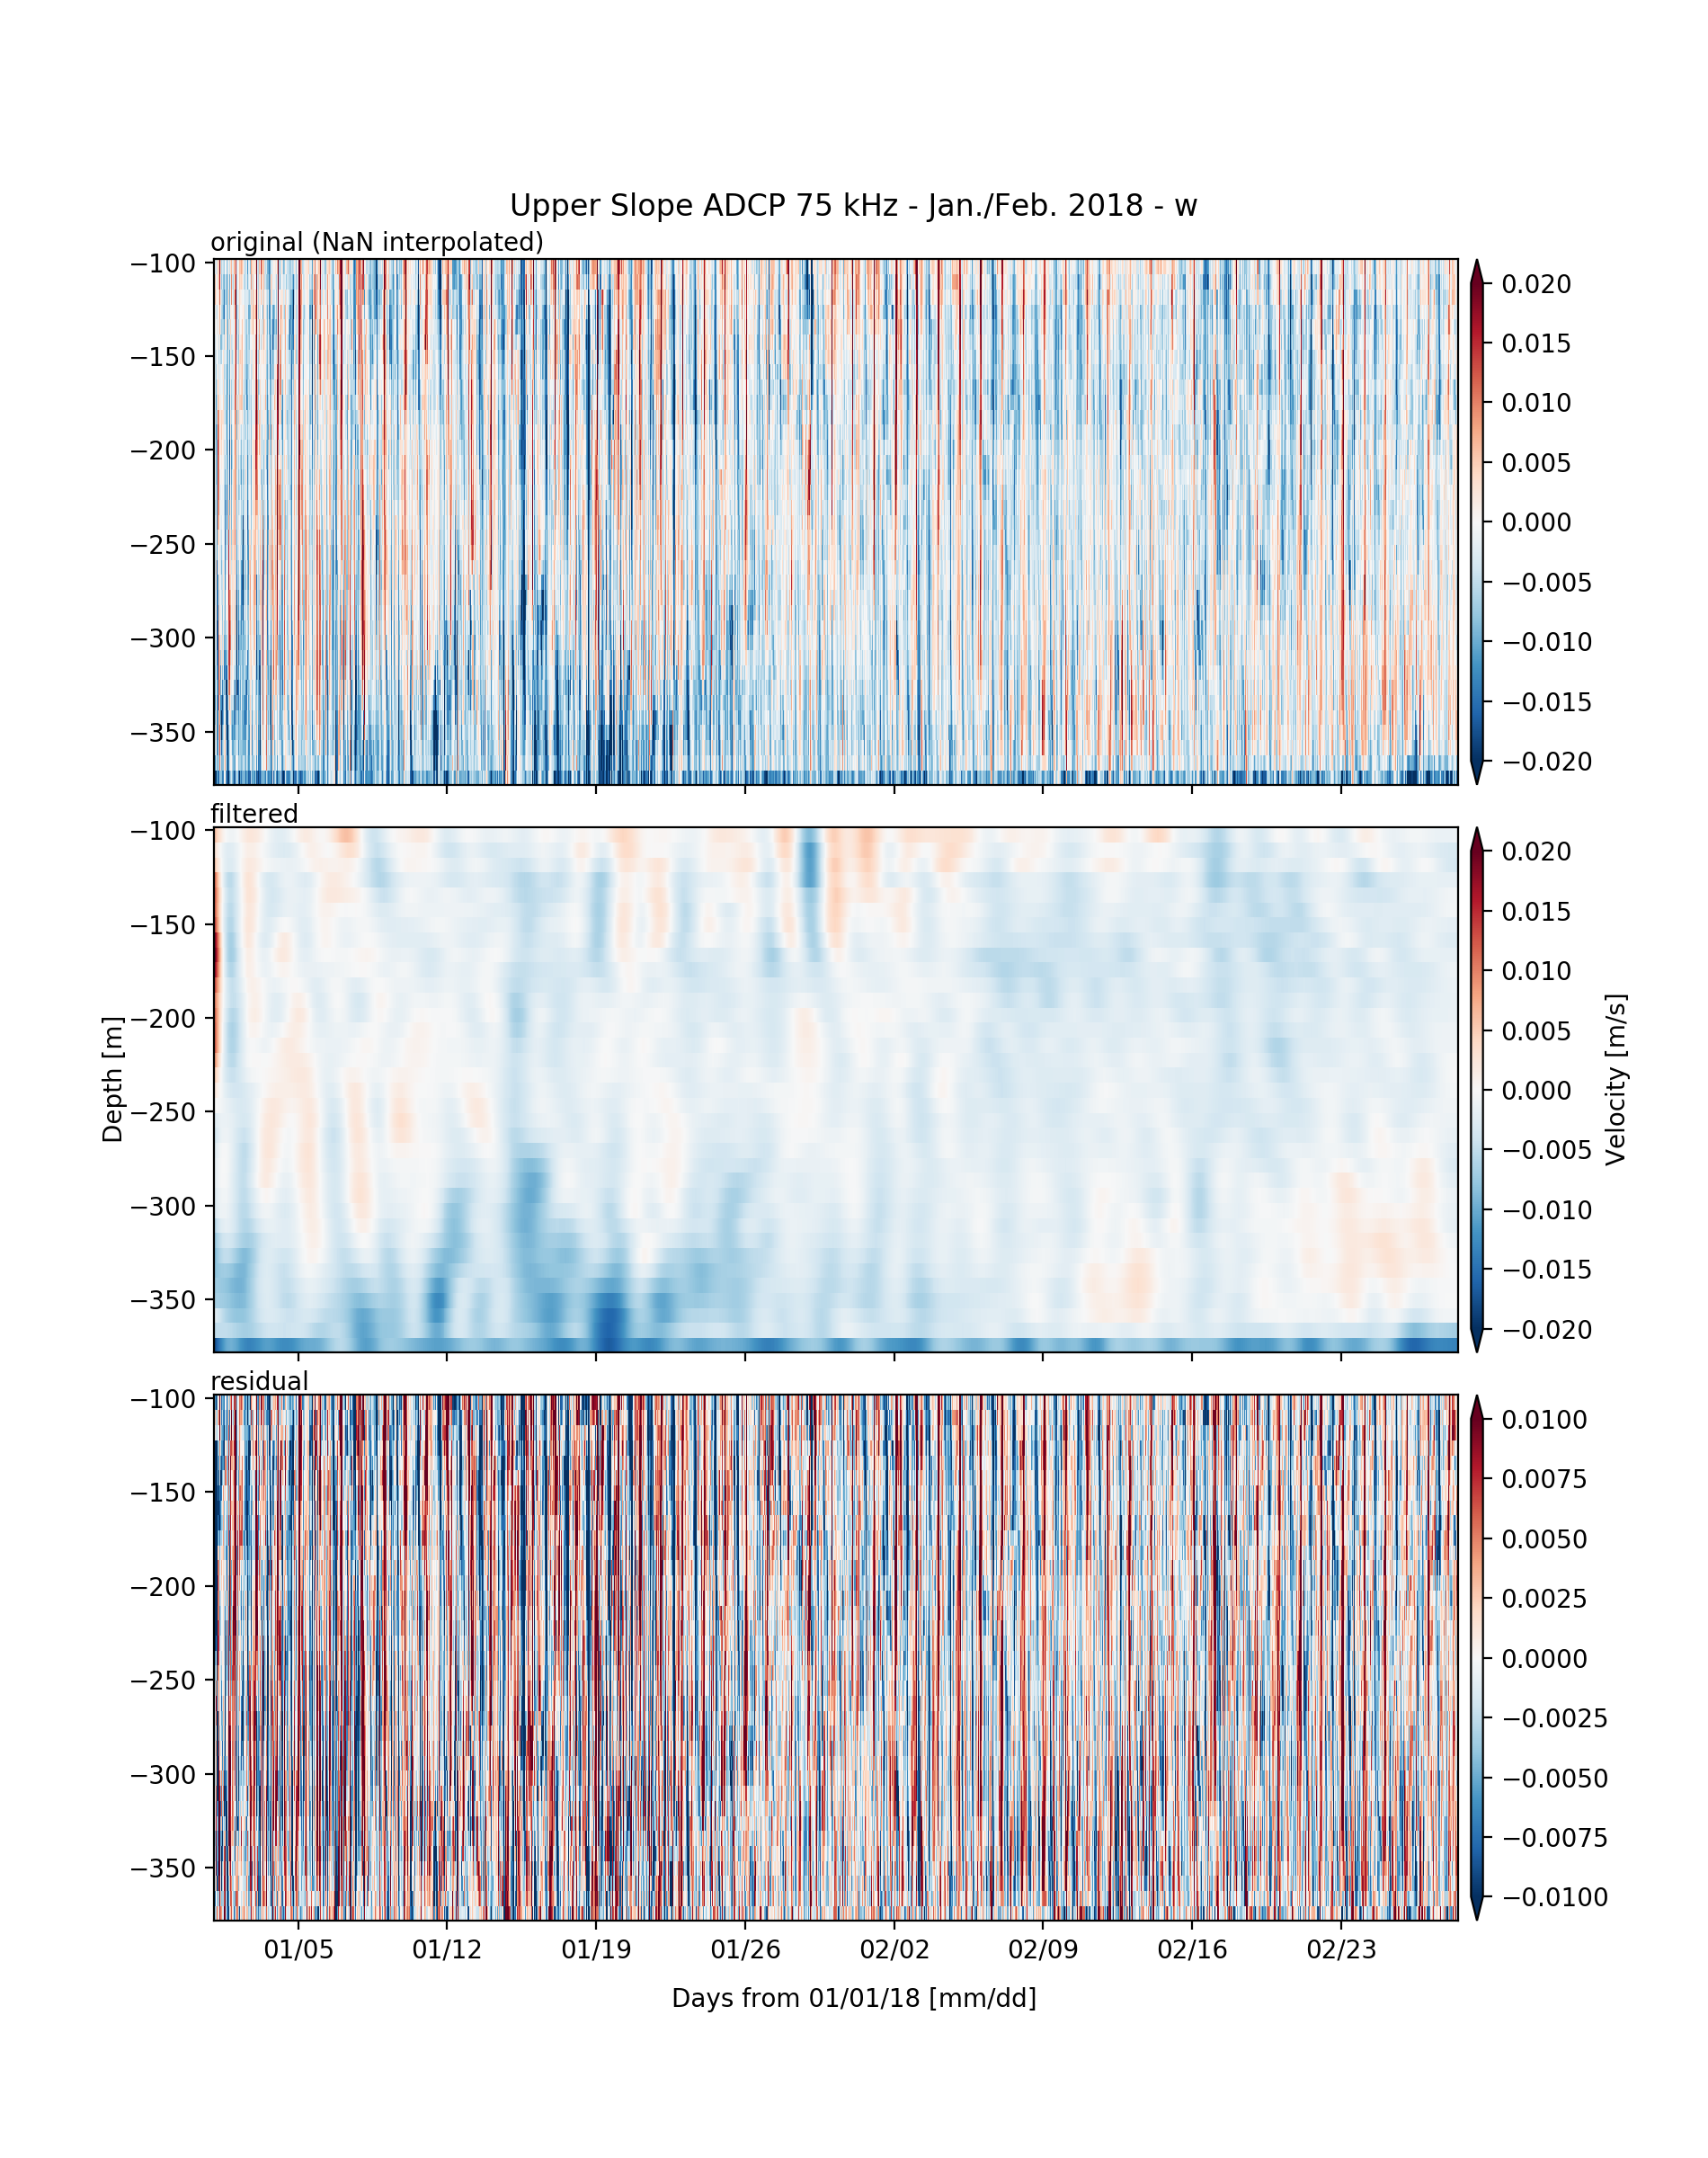

In [24]:
# plot w data

fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(9.5,12), sharex = True)
fig.subplots_adjust(hspace = 0.08)
fig.text(0.5, 0.9, 'Upper Slope ADCP 75 kHz - Jan./Feb. 2018 - w', ha='center', fontsize=12)
fig.text(0.06, 0.5, 'Depth [m]', va='center', rotation='vertical')
fig.text(0.123, 0.887, 'original (NaN interpolated)', va='center')
fig.text(0.123, 0.622, 'filtered', va='center')
fig.text(0.123, 0.359, 'residual', va='center')
fig.text(0.94, 0.5, 'Velocity [m/s]', va='center', rotation='vertical')
fig.text(0.5, 0.07, 'Days from 01/01/18 [mm/dd]', ha='center')

im1 = ax1.pcolormesh(ds.time, -depth, worig.T, rasterized=True, cmap='RdBu_r', vmin=-0.02, vmax=0.02)
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=40, extend='both')

im2 = ax2.pcolormesh(ds.time, -depth, wlp.T, rasterized=True, cmap='RdBu_r', vmin=-0.02, vmax=0.02)
cbar2 = fig.colorbar(im2, ax=ax2, fraction=0.05, pad=0.01, aspect=40, extend='both')

im3 = ax3.pcolormesh(ds.time, -depth, whp.T, rasterized=True, cmap='RdBu_r', vmin=-0.01, vmax=0.01)
cbar3 = fig.colorbar(im3, ax=ax3, fraction=0.05, pad=0.01, aspect=40, extend='both')

date_form = pldates.DateFormatter("%m/%d")
ax3.xaxis.set_major_formatter(date_form)

In [25]:
theta_along_slope = np.radians(30)                       # rotation angle in radians, test = 20 degrees
ulp_vec = ulp + 1j*vlp                                   # vector form of horizontal velocity
ulp_vec_new = ulp_vec*np.exp(-1j*theta_along_slope)      # rotated velocity vector
ulp_rot = np.real(ulp_vec_new)                           # u_new = Re(rotated vector)
vlp_rot = np.imag(ulp_vec_new)                           # v_new = Im(rotated vector)

<IPython.core.display.Javascript object>


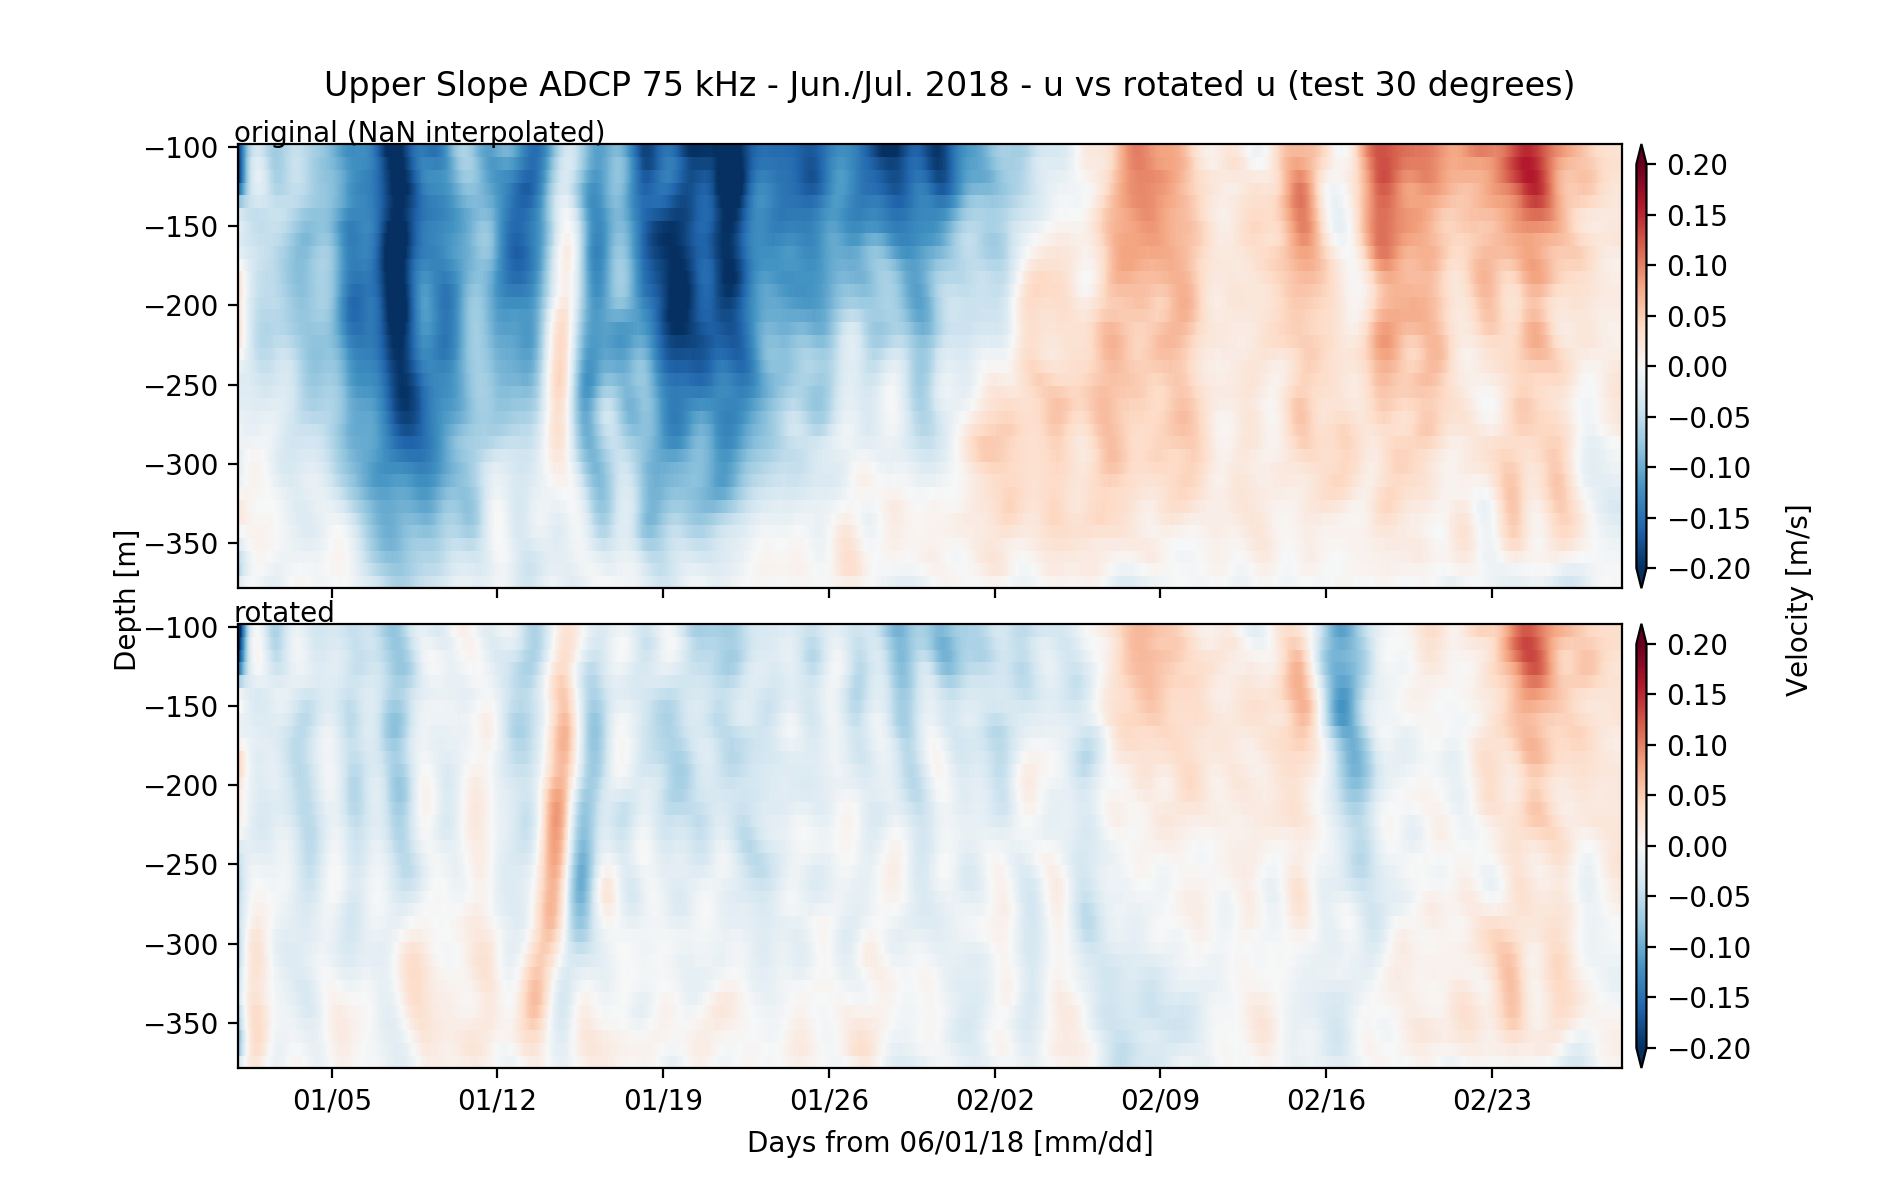

In [29]:
# test plot u data

fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(9.5,6), sharex = True)
fig.subplots_adjust(hspace = 0.08)
fig.text(0.5, 0.92, 'Upper Slope ADCP 75 kHz - Jun./Jul. 2018 - u vs rotated u (test 30 degrees)', \
         ha='center', fontsize=12)
fig.text(0.06, 0.5, 'Depth [m]', va='center', rotation='vertical')
fig.text(0.123, 0.888, 'original (NaN interpolated)', va='center')
fig.text(0.123, 0.488, 'rotated', va='center')
fig.text(0.94, 0.5, 'Velocity [m/s]', va='center', rotation='vertical')
fig.text(0.5, 0.04, 'Days from 06/01/18 [mm/dd]', ha='center')

im1 = ax1.pcolormesh(ds.time, -depth, ulp.T, rasterized=True, cmap='RdBu_r', vmin=-0.20, vmax=0.20)
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=40, extend='both')

im2 = ax2.pcolormesh(ds.time, -depth, ulp_rot.T, rasterized=True, cmap='RdBu_r', vmin=-0.20, vmax=0.20)
cbar2 = fig.colorbar(im2, ax=ax2, fraction=0.05, pad=0.01, aspect=40, extend='both')

date_form = pldates.DateFormatter("%m/%d")
ax2.xaxis.set_major_formatter(date_form)

<IPython.core.display.Javascript object>


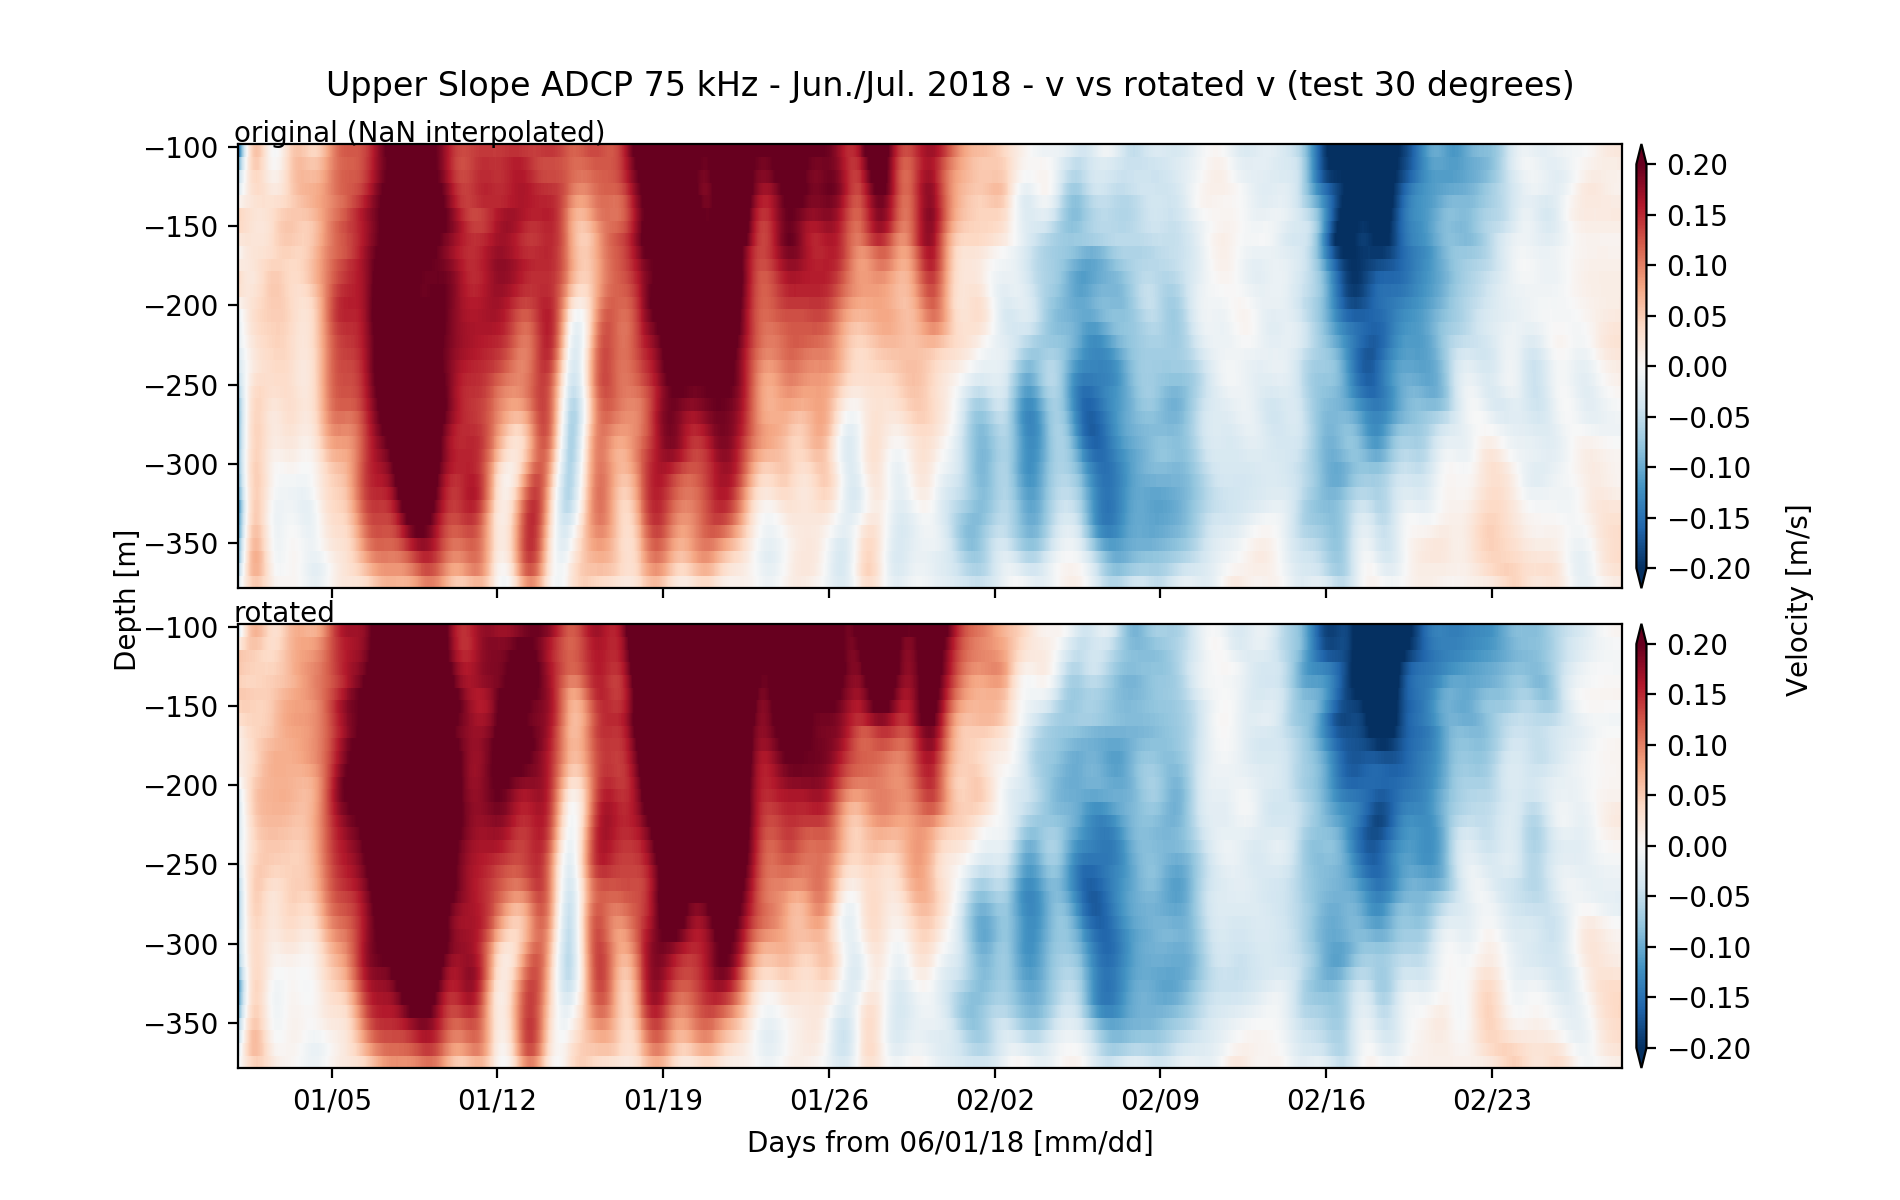

In [28]:
# test plot v data

fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(9.5,6), sharex = True)
fig.subplots_adjust(hspace = 0.08)
fig.text(0.5, 0.92, 'Upper Slope ADCP 75 kHz - Jun./Jul. 2018 - v vs rotated v (test 30 degrees)', \
         ha='center', fontsize=12)
fig.text(0.06, 0.5, 'Depth [m]', va='center', rotation='vertical')
fig.text(0.123, 0.888, 'original (NaN interpolated)', va='center')
fig.text(0.123, 0.488, 'rotated', va='center')
fig.text(0.94, 0.5, 'Velocity [m/s]', va='center', rotation='vertical')
fig.text(0.5, 0.04, 'Days from 06/01/18 [mm/dd]', ha='center')

im1 = ax1.pcolormesh(ds.time, -depth, vlp.T, rasterized=True, cmap='RdBu_r', vmin=-0.20, vmax=0.20)
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=40, extend='both')

im2 = ax2.pcolormesh(ds.time, -depth, vlp_rot.T, rasterized=True, cmap='RdBu_r', vmin=-0.20, vmax=0.20)
cbar2 = fig.colorbar(im2, ax=ax2, fraction=0.05, pad=0.01, aspect=40, extend='both')

date_form = pldates.DateFormatter("%m/%d")
ax2.xaxis.set_major_formatter(date_form)